# Pretrained Models

## Imports and Data

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import models, datasets, transforms
from torch import nn, optim
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)), #resize the image to 224x224
    transforms.ToTensor(),  #convert the image to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize the image
])

Dataset using Sams data and tested on teachers given data

In [4]:
"""
dataset = datasets.ImageFolder(root='./dataset/dataset', transform=data_transform)

class_names = dataset.classes

train_size = 0.80
val_size = 0.20


#dataset given by teacher

testData = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)


# Split indices into training and combined validation/test indices
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=(val_size), random_state=42)


train_set = Subset(dataset, train_indices)  # Subset for training datata
test_set = testData               # Subset for validation data given by teacher
val_set = Subset(dataset, val_indices)    # Subset for test data
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
"""

"\ndataset = datasets.ImageFolder(root='./dataset/dataset', transform=data_transform)\n\nclass_names = dataset.classes\n\ntrain_size = 0.80\nval_size = 0.20\n\n\n#dataset given by teacher\n\ntestData = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)\n\n\n# Split indices into training and combined validation/test indices\ntrain_indices, val_indices = train_test_split(range(len(dataset)), test_size=(val_size), random_state=42)\n\n\ntrain_set = Subset(dataset, train_indices)  # Subset for training datata\ntest_set = testData               # Subset for validation data given by teacher\nval_set = Subset(dataset, val_indices)    # Subset for test data\nbatch_size = 32\ntrain_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)\nvalid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)\n"

Data for combined data

In [5]:
dataset = datasets.ImageFolder(root='./CombinedData', transform=data_transform)

class_names = dataset.classes

train_size = 0.70
val_size = 0.15
test_size = 0.15


# Split indices into training and combined validation/test indices
train_indices, val_test_indices = train_test_split(range(len(dataset)), test_size=(val_size + test_size), random_state=42)

# Split indices into validation and test indices
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_size/(val_size + test_size), random_state=42)

train_set = Subset(dataset, train_indices)  # Subset for training datata
test_set = Subset(dataset, test_indices)    # Subset for validation data given by teacher
val_set = Subset(dataset, val_indices)    # Subset for test data

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Data set tested on just teachers data

In [6]:
#dataset tests for only teacher data
'''
teachers_Data = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)

test_ratio = 0.15
train_ratio = 0.7
val_ratio = 0.15

# Split indices into training and combined validation/test indices
train_indices, val_test_indices = train_test_split(range(len(teachers_Data)), test_size=(test_ratio + val_ratio), random_state=42)

# Split indices into validation and test indices
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)

train_set = Subset(teachers_Data, train_indices)  # Subset for training data
val_set = Subset(teachers_Data, val_indices)      # Subset for validation data
test_set = Subset(teachers_Data, test_indices)    # Subset for test data
'''

"\nteachers_Data = datasets.ImageFolder(root='./FoodDatasetComplete', transform=data_transform)\n\ntest_ratio = 0.15\ntrain_ratio = 0.7\nval_ratio = 0.15\n\n# Split indices into training and combined validation/test indices\ntrain_indices, val_test_indices = train_test_split(range(len(teachers_Data)), test_size=(test_ratio + val_ratio), random_state=42)\n\n# Split indices into validation and test indices\nval_indices, test_indices = train_test_split(val_test_indices, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)\n\ntrain_set = Subset(teachers_Data, train_indices)  # Subset for training data\nval_set = Subset(teachers_Data, val_indices)      # Subset for validation data\ntest_set = Subset(teachers_Data, test_indices)    # Subset for test data\n"

## Model Functions

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [8]:
def trainModel(model, setepochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    custom_callback = CustomCallback()
    custom_callback.set_optimizer(optimizer)
    model.to(device)
    custom_callback.set_model(model)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)
    train_losses = []  # List to store training losses
    train_accuracies = []  # List to store training accuracies
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies

    # Training loop
    num_epochs = setepochs  # Number of epochs for training
    for epoch in range(num_epochs):
        # Training
        model.train()  # Set the model to training mode
        running_train_loss = 0.0  # Initialize running training loss
        correct_train = 0  # Initialize number of correctly predicted training samples
        total_train = 0  # Initialize total number of training samples
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize parameters

            running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_train += labels.size(0)  # Increment total training samples
            correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

        # Calculate epoch-wise training loss and accuracy
        epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
        train_accuracy = correct_train / total_train  # Training accuracy

        # Validation
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0  # Initialize running validation loss
        correct_val = 0  # Initialize number of correctly predicted validation samples
        total_val = 0  # Initialize total number of validation samples
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                outputs = model(inputs)  # Forward pass
                if isinstance(outputs, tuple):
                    logits = outputs[0]  # Unpack logits if model returns tuple
                else:
                    logits = outputs
                loss = criterion(logits, labels)  # Calculate loss

                running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
                _, predicted = torch.max(logits, 1)  # Get predicted labels
                total_val += labels.size(0)  # Increment total validation samples
                correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

        # Calculate epoch-wise validation loss and accuracy
        epoch_val_loss = running_val_loss / len(valid_loader.dataset)  # Average validation loss
        val_accuracy = correct_val / total_val  # Validation accuracy

        # Append values to lists
        train_losses.append(epoch_train_loss)  # Append training loss
        train_accuracies.append(train_accuracy)  # Append training accuracy
        val_losses.append(epoch_val_loss)  # Append validation loss
        val_accuracies.append(val_accuracy)  # Append validation accuracy

        # Step LR scheduler
        lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

        # Check early stopping
        if custom_callback.on_epoch_end(epoch, epoch_val_loss):
            break  # Stop training if early stopping criterion is met

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation accuracies
    plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Accuracy')  # Set label for the y-axis
    plt.title('Training and Validation Accuracies')  # Set title for the plot
    plt.legend()  # Display legend
    plt.show()  # Show the plot
    # Plot training and validation losses starting from index 1
    epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

    # Plot training and validation losses
    plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
    plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
    plt.xlabel('Epoch')  # Set label for the x-axis
    plt.ylabel('Loss')  # Set label for the y-axis
    plt.title('Training and Validation Losses')  # Set title for the plot
    plt.legend()  # Display legend
    plt.grid(True)  # Display grid
    plt.show()  # Show the plot

In [9]:
def evalModel(model, criterion):
    model.eval()  # Set model to evaluation mode
    test_correct = 0  # Initialize number of correctly predicted samples
    test_total = 0  # Initialize total number of samples
    test_running_loss = 0.0  # Initialize running test loss

    with torch.no_grad():  # Turn off gradients during evaluation
        for inputs, labels in test_loader:  # Iterate through test data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)  # Get model predictions
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits from model outputs if necessary
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            test_total += labels.size(0)  # Update total number of samples
            test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

    # Calculate test loss and accuracy
    test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
    test_accuracy = test_correct / test_total  # Test accuracy

    # Print test results
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

## GoogLeNet

### Model

#### Load Model

In [10]:
default_weight_googlenet = models.GoogLeNet_Weights.DEFAULT
googlenet_model = models.googlenet(weights=default_weight_googlenet)

In [11]:
for param in googlenet_model.parameters():
    param.requires_grad = False

In [12]:
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_googlenet_model = googlenet_model


#### Training


In [13]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)), #resize the image to 224x224
    transforms.ToTensor(),  #convert the image to a pytorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #normalize the image
])

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.5857, Train Accuracy: 0.1626, Val Loss: 3.4453, Val Accuracy: 0.2940
Epoch [2/10], Train Loss: 3.3494, Train Accuracy: 0.4028, Val Loss: 3.3015, Val Accuracy: 0.4410
Epoch [3/10], Train Loss: 3.2816, Train Accuracy: 0.4603, Val Loss: 3.2830, Val Accuracy: 0.4598
Epoch [4/10], Train Loss: 3.2653, Train Accuracy: 0.4742, Val Loss: 3.2723, Val Accuracy: 0.4667
Epoch [5/10], Train Loss: 3.2423, Train Accuracy: 0.4936, Val Loss: 3.2667, Val Accuracy: 0.4650
Epoch [6/10], Train Loss: 3.2221, Train Accuracy: 0.5137, Val Loss: 3.2436, Val Accuracy: 0.4974
Epoch [7/10], Train Loss: 3.2134, Train Accuracy: 0.5240, Val Loss: 3.2249, Val Accuracy: 0.5094
Epoch [8/10], Train Loss: 3.1985, Train Accuracy: 0.5372, Val Loss: 3.2340, Val Accuracy: 0.5026
Epoch [9/10], Train Loss: 3.1754, Train Accuracy: 0.5624, Val Loss: 3.2080, Val Accuracy: 0.5265
Epoch [10/10], Train Loss: 3.1657, Train Accuracy: 0.5679, Val Loss: 3.1964, Val Accuracy: 0.5350


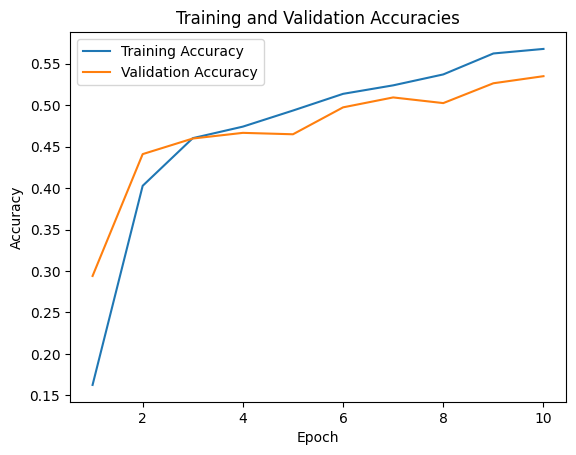

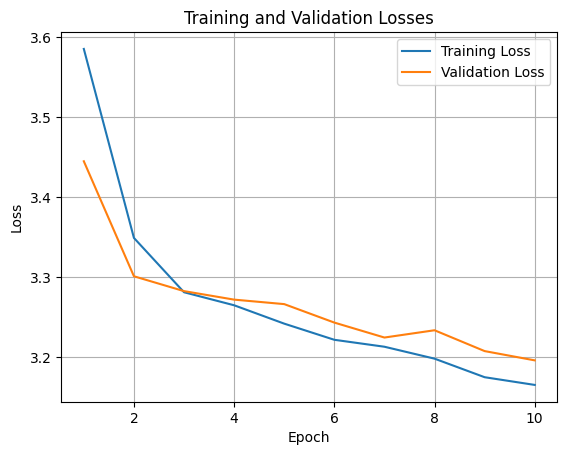

In [14]:
trainModel(tuned_googlenet_model, 10)

In [15]:
evalModel(tuned_googlenet_model, nn.CrossEntropyLoss())

Test Loss: 3.1893, Test Accuracy: 0.5495


## MobileNet V3

### Model Small

#### Load Model

In [16]:
default_weight_mobilenet = models.MobileNet_V3_Small_Weights.DEFAULT
mobilenet_model = models.mobilenet_v3_small(weights=default_weight_mobilenet)

In [17]:
# Freeze all layers
for param in mobilenet_model.parameters():
    param.requires_grad = False

In [18]:
num_features = mobilenet_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_mobilenet_model = mobilenet_model

tuned_mobilenet_model.classifier = new_head



#### Training

Epoch [1/10], Train Loss: 3.5855, Train Accuracy: 0.1582, Val Loss: 3.4523, Val Accuracy: 0.2855
Epoch [2/10], Train Loss: 3.4013, Train Accuracy: 0.3427, Val Loss: 3.3620, Val Accuracy: 0.3761
Epoch [3/10], Train Loss: 3.3330, Train Accuracy: 0.4064, Val Loss: 3.3212, Val Accuracy: 0.4103
Epoch [4/10], Train Loss: 3.3050, Train Accuracy: 0.4302, Val Loss: 3.2953, Val Accuracy: 0.4410
Epoch [5/10], Train Loss: 3.2812, Train Accuracy: 0.4544, Val Loss: 3.2812, Val Accuracy: 0.4513
Epoch [6/10], Train Loss: 3.2512, Train Accuracy: 0.4848, Val Loss: 3.2630, Val Accuracy: 0.4701
Epoch [7/10], Train Loss: 3.2308, Train Accuracy: 0.5049, Val Loss: 3.2315, Val Accuracy: 0.5043
Epoch [8/10], Train Loss: 3.2152, Train Accuracy: 0.5159, Val Loss: 3.2333, Val Accuracy: 0.5043
Epoch [9/10], Train Loss: 3.2078, Train Accuracy: 0.5258, Val Loss: 3.2176, Val Accuracy: 0.5179
Epoch [10/10], Train Loss: 3.1816, Train Accuracy: 0.5511, Val Loss: 3.2037, Val Accuracy: 0.5350


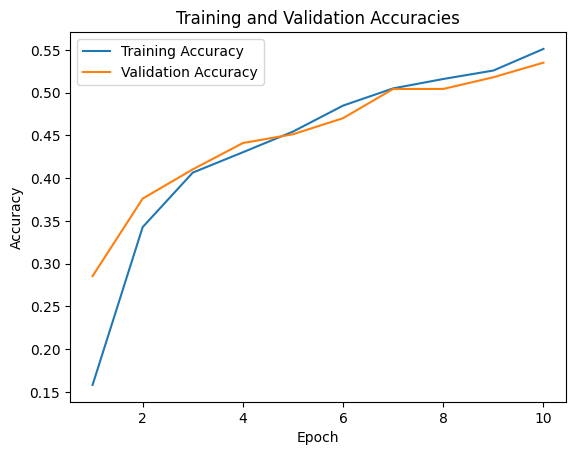

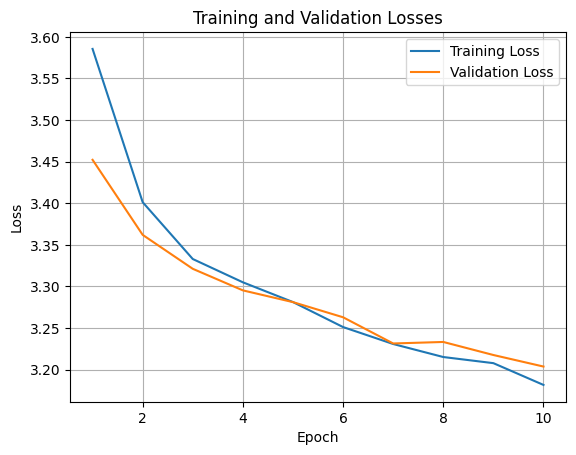

In [19]:
trainModel(tuned_mobilenet_model, 10)

In [20]:
evalModel(tuned_mobilenet_model, nn.CrossEntropyLoss())

Test Loss: 3.2251, Test Accuracy: 0.5102


### Model Large

#### Load Model

In [21]:
default_weight_mobilenet_Large = models.MobileNet_V3_Large_Weights.DEFAULT
mobilenet_large_model = models.mobilenet_v3_large(weights=default_weight_mobilenet_Large)

In [22]:
# Freeze all layers
for param in mobilenet_large_model.parameters():
    param.requires_grad = False

In [23]:
num_features = mobilenet_large_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_mobilenet_large_model = mobilenet_large_model


tuned_mobilenet_large_model.classifier = new_head


#### Training


Epoch [1/10], Train Loss: 3.4867, Train Accuracy: 0.2779, Val Loss: 3.2953, Val Accuracy: 0.4735
Epoch [2/10], Train Loss: 3.1936, Train Accuracy: 0.5529, Val Loss: 3.1872, Val Accuracy: 0.5556
Epoch [3/10], Train Loss: 3.1014, Train Accuracy: 0.6415, Val Loss: 3.1443, Val Accuracy: 0.5863
Epoch [4/10], Train Loss: 3.0729, Train Accuracy: 0.6639, Val Loss: 3.0990, Val Accuracy: 0.6342
Epoch [5/10], Train Loss: 3.0526, Train Accuracy: 0.6811, Val Loss: 3.1186, Val Accuracy: 0.6137
Epoch [6/10], Train Loss: 3.0451, Train Accuracy: 0.6891, Val Loss: 3.1010, Val Accuracy: 0.6342
Epoch [7/10], Train Loss: 3.0326, Train Accuracy: 0.7016, Val Loss: 3.0726, Val Accuracy: 0.6684
Epoch [8/10], Train Loss: 3.0115, Train Accuracy: 0.7246, Val Loss: 3.0629, Val Accuracy: 0.6735
Epoch [9/10], Train Loss: 3.0020, Train Accuracy: 0.7334, Val Loss: 3.0666, Val Accuracy: 0.6632
Epoch [10/10], Train Loss: 2.9976, Train Accuracy: 0.7367, Val Loss: 3.0606, Val Accuracy: 0.6769


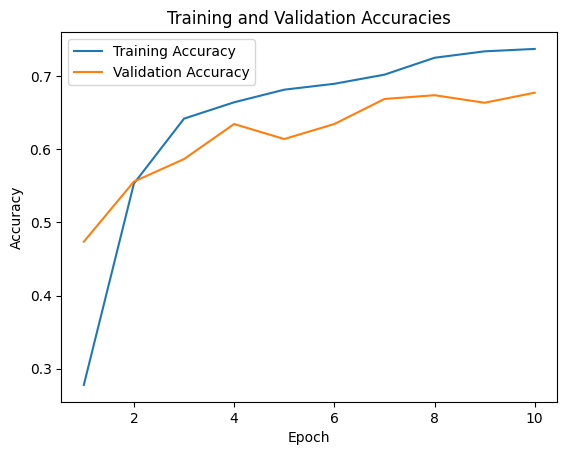

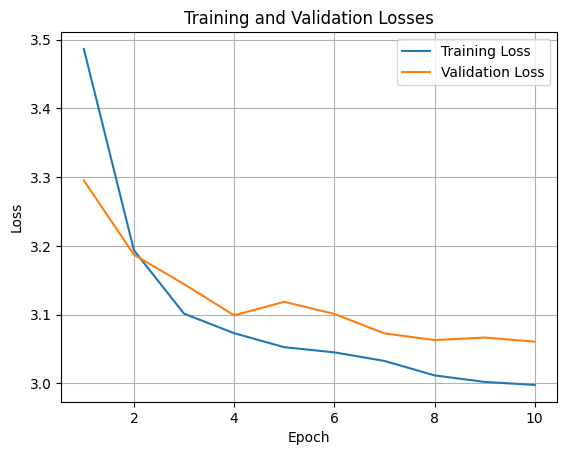

In [24]:
trainModel(tuned_mobilenet_large_model, 10)

In [25]:
evalModel(tuned_mobilenet_large_model, nn.CrossEntropyLoss())

Test Loss: 3.0434, Test Accuracy: 0.6911


## AlexNet

### Load Model

In [26]:
default_weight_AlexNet = models.AlexNet_Weights.DEFAULT
alexnet_model = models.alexnet(weights=default_weight_AlexNet)

In [27]:
#freeze all layers
for param in alexnet_model.parameters():
    param.requires_grad = False

In [28]:
num_features = alexnet_model.classifier[6].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_alexnet_model = alexnet_model

tuned_alexnet_model.classifier[6] = new_head



In [29]:
print(tuned_alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Training


Epoch [1/10], Train Loss: 3.4152, Train Accuracy: 0.3288, Val Loss: 3.3628, Val Accuracy: 0.3641
Epoch [2/10], Train Loss: 3.2880, Train Accuracy: 0.4456, Val Loss: 3.2742, Val Accuracy: 0.4632
Epoch [3/10], Train Loss: 3.2369, Train Accuracy: 0.4962, Val Loss: 3.2997, Val Accuracy: 0.4291
Epoch [4/10], Train Loss: 3.2259, Train Accuracy: 0.5057, Val Loss: 3.3001, Val Accuracy: 0.4291
Epoch [5/10], Train Loss: 3.2217, Train Accuracy: 0.5101, Val Loss: 3.2663, Val Accuracy: 0.4615
Epoch [6/10], Train Loss: 3.2048, Train Accuracy: 0.5262, Val Loss: 3.2549, Val Accuracy: 0.4752
Epoch [7/10], Train Loss: 3.1906, Train Accuracy: 0.5408, Val Loss: 3.2346, Val Accuracy: 0.4991
Epoch [8/10], Train Loss: 3.1815, Train Accuracy: 0.5500, Val Loss: 3.2295, Val Accuracy: 0.4991
Epoch [9/10], Train Loss: 3.1461, Train Accuracy: 0.5848, Val Loss: 3.1903, Val Accuracy: 0.5385
Epoch [10/10], Train Loss: 3.1268, Train Accuracy: 0.6038, Val Loss: 3.1930, Val Accuracy: 0.5453


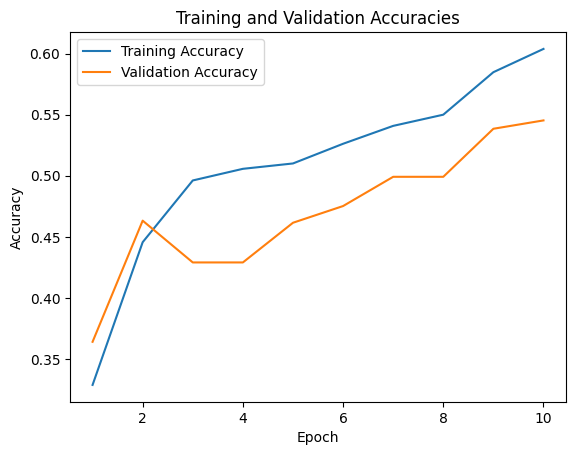

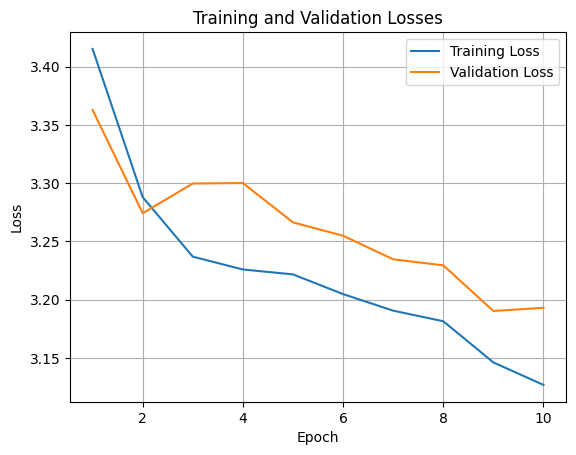

In [30]:
trainModel(tuned_alexnet_model, 10)

In [31]:
evalModel(tuned_alexnet_model, nn.CrossEntropyLoss())

Test Loss: 3.1701, Test Accuracy: 0.5563


## ConvNeXt

### Models


#### Tiny

##### Load Model

In [32]:
default_weight_ConvNeXt_tiny = models.ConvNeXt_Tiny_Weights.DEFAULT
convnext_tiny_model = models.convnext_tiny(weights=default_weight_ConvNeXt_tiny)

In [33]:
#freeze all layers
for param in convnext_tiny_model.parameters():
    param.requires_grad = False

In [34]:
num_features = convnext_tiny_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_tiny_model = convnext_tiny_model

tuned_convnext_tiny_model.classifier[2] = new_head

In [35]:
print(tuned_convnext_tiny_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

##### Training 


Epoch [1/10], Train Loss: 3.3765, Train Accuracy: 0.4028, Val Loss: 3.2174, Val Accuracy: 0.5179
Epoch [2/10], Train Loss: 3.1343, Train Accuracy: 0.6027, Val Loss: 3.1488, Val Accuracy: 0.5880
Epoch [3/10], Train Loss: 3.0890, Train Accuracy: 0.6448, Val Loss: 3.1321, Val Accuracy: 0.5983
Epoch [4/10], Train Loss: 3.0713, Train Accuracy: 0.6606, Val Loss: 3.1374, Val Accuracy: 0.5932
Epoch [5/10], Train Loss: 3.0334, Train Accuracy: 0.7030, Val Loss: 3.0653, Val Accuracy: 0.6667
Epoch [6/10], Train Loss: 2.9981, Train Accuracy: 0.7345, Val Loss: 3.0659, Val Accuracy: 0.6718
Epoch [7/10], Train Loss: 2.9922, Train Accuracy: 0.7404, Val Loss: 3.0564, Val Accuracy: 0.6735
Epoch [8/10], Train Loss: 2.9822, Train Accuracy: 0.7492, Val Loss: 3.0394, Val Accuracy: 0.6923
Epoch [9/10], Train Loss: 2.9647, Train Accuracy: 0.7671, Val Loss: 3.0288, Val Accuracy: 0.7060
Epoch [10/10], Train Loss: 2.9500, Train Accuracy: 0.7825, Val Loss: 3.0185, Val Accuracy: 0.7145


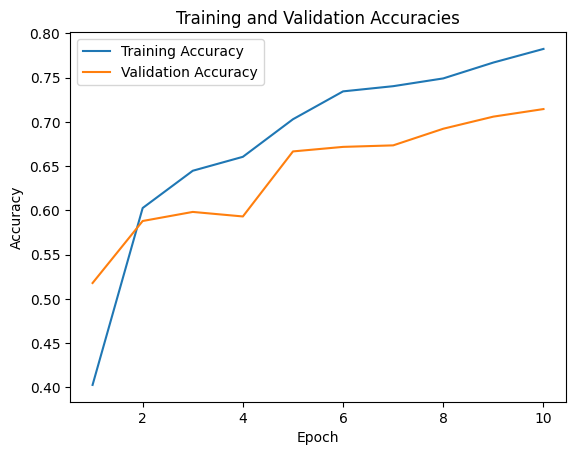

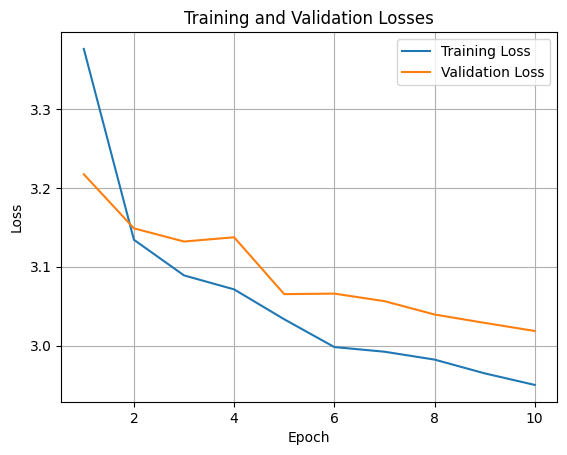

In [36]:
trainModel(tuned_convnext_tiny_model, 10)

In [37]:
evalModel(tuned_convnext_tiny_model, nn.CrossEntropyLoss())

Test Loss: 2.9911, Test Accuracy: 0.7406


#### Small


##### Load Model


In [38]:
default_weight_ConvNeXt_small = models.ConvNeXt_Small_Weights.DEFAULT
convnext_small_model = models.convnext_small(weights=default_weight_ConvNeXt_small)

In [39]:
#freeze all layers
for param in convnext_small_model.parameters():
    param.requires_grad = False

In [40]:
num_features = convnext_small_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_small_model = convnext_small_model

tuned_convnext_small_model.classifier[2] = new_head

In [41]:
print(tuned_convnext_small_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

##### Training


Epoch [1/10], Train Loss: 3.3776, Train Accuracy: 0.4075, Val Loss: 3.1806, Val Accuracy: 0.5641
Epoch [2/10], Train Loss: 3.1441, Train Accuracy: 0.5914, Val Loss: 3.1342, Val Accuracy: 0.5983
Epoch [3/10], Train Loss: 3.1020, Train Accuracy: 0.6302, Val Loss: 3.1011, Val Accuracy: 0.6342
Epoch [4/10], Train Loss: 3.0769, Train Accuracy: 0.6554, Val Loss: 3.0829, Val Accuracy: 0.6564
Epoch [5/10], Train Loss: 3.0431, Train Accuracy: 0.6877, Val Loss: 3.0616, Val Accuracy: 0.6667
Epoch [6/10], Train Loss: 3.0195, Train Accuracy: 0.7144, Val Loss: 3.0180, Val Accuracy: 0.7197
Epoch [7/10], Train Loss: 3.0115, Train Accuracy: 0.7206, Val Loss: 3.0287, Val Accuracy: 0.7060
Epoch [8/10], Train Loss: 3.0075, Train Accuracy: 0.7232, Val Loss: 3.0272, Val Accuracy: 0.7060
Epoch [9/10], Train Loss: 3.0001, Train Accuracy: 0.7312, Val Loss: 3.0035, Val Accuracy: 0.7316
Epoch [10/10], Train Loss: 2.9802, Train Accuracy: 0.7547, Val Loss: 2.9943, Val Accuracy: 0.7368


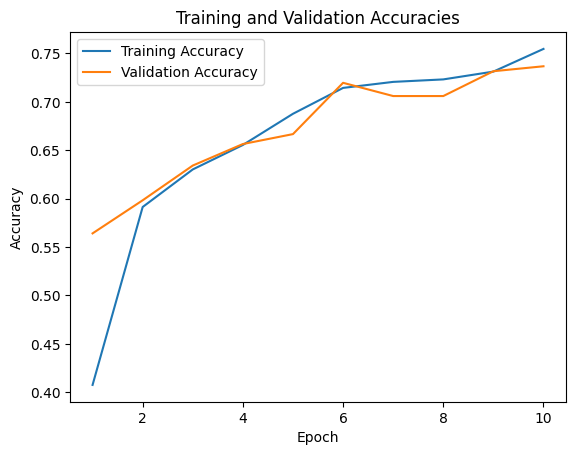

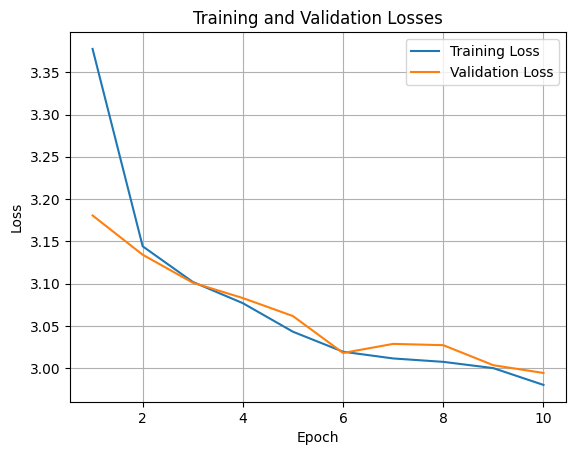

In [42]:
trainModel(tuned_convnext_small_model, 10)

In [43]:
evalModel(tuned_convnext_small_model, nn.CrossEntropyLoss())

Test Loss: 3.0041, Test Accuracy: 0.7287


#### Base

##### Load Model

In [44]:
default_weight_ConvNeXt_base = models.ConvNeXt_Base_Weights.DEFAULT
convnext_base_model = models.convnext_base(weights=default_weight_ConvNeXt_base)

In [45]:
#freeze all layers
for param in convnext_base_model.parameters():
    param.requires_grad = False

In [46]:
num_features = convnext_base_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_base_model = convnext_base_model\

tuned_convnext_base_model.classifier[2] = new_head

tuned_convnext_base_model = convnext_base_model

In [47]:
print(tuned_convnext_base_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

Epoch [1/10], Train Loss: 3.3772, Train Accuracy: 0.4002, Val Loss: 3.1423, Val Accuracy: 0.5983
Epoch [2/10], Train Loss: 3.0768, Train Accuracy: 0.6639, Val Loss: 3.0787, Val Accuracy: 0.6547
Epoch [3/10], Train Loss: 3.0339, Train Accuracy: 0.7012, Val Loss: 3.0529, Val Accuracy: 0.6855
Epoch [4/10], Train Loss: 3.0185, Train Accuracy: 0.7166, Val Loss: 3.0499, Val Accuracy: 0.6821
Epoch [5/10], Train Loss: 3.0108, Train Accuracy: 0.7228, Val Loss: 3.0275, Val Accuracy: 0.7060
Epoch [6/10], Train Loss: 2.9898, Train Accuracy: 0.7430, Val Loss: 3.0069, Val Accuracy: 0.7282
Epoch [7/10], Train Loss: 2.9693, Train Accuracy: 0.7657, Val Loss: 2.9769, Val Accuracy: 0.7556
Epoch [8/10], Train Loss: 2.9559, Train Accuracy: 0.7774, Val Loss: 2.9796, Val Accuracy: 0.7538
Epoch [9/10], Train Loss: 2.9542, Train Accuracy: 0.7774, Val Loss: 2.9997, Val Accuracy: 0.7333
Epoch [10/10], Train Loss: 2.9565, Train Accuracy: 0.7763, Val Loss: 2.9778, Val Accuracy: 0.7573


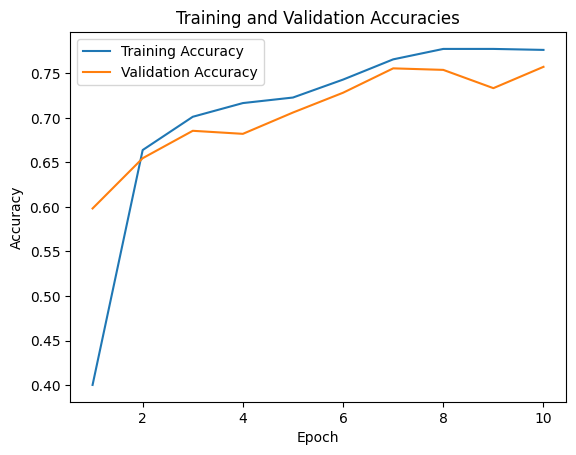

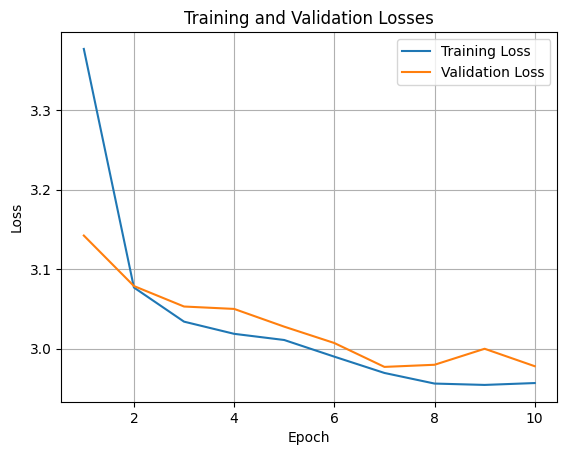

In [48]:
trainModel(tuned_convnext_base_model, 10)

In [49]:
evalModel(tuned_convnext_base_model, nn.CrossEntropyLoss())

Test Loss: 2.9760, Test Accuracy: 0.7560


#### Large

##### Load Model

In [50]:
default_weight_ConvNeXt_large = models.ConvNeXt_Large_Weights.DEFAULT
convnext_large_model = models.convnext_large(weights=default_weight_ConvNeXt_large)

In [51]:
#freeze all layers
for param in convnext_large_model.parameters():
    param.requires_grad = False

In [52]:
num_features = convnext_large_model.classifier[2].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_convnext_large_model = convnext_large_model

tuned_convnext_large_model.classifier[2] = new_head



In [53]:
print(tuned_convnext_base_model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

##### Training

Epoch [1/10], Train Loss: 3.4009, Train Accuracy: 0.3896, Val Loss: 3.1719, Val Accuracy: 0.5692
Epoch [2/10], Train Loss: 3.0907, Train Accuracy: 0.6554, Val Loss: 3.0553, Val Accuracy: 0.6855
Epoch [3/10], Train Loss: 3.0184, Train Accuracy: 0.7199, Val Loss: 3.0315, Val Accuracy: 0.7026
Epoch [4/10], Train Loss: 2.9990, Train Accuracy: 0.7345, Val Loss: 3.0343, Val Accuracy: 0.7009
Epoch [5/10], Train Loss: 2.9994, Train Accuracy: 0.7342, Val Loss: 3.0398, Val Accuracy: 0.6991
Epoch [6/10], Train Loss: 2.9964, Train Accuracy: 0.7360, Val Loss: 3.0276, Val Accuracy: 0.7026
Epoch [7/10], Train Loss: 2.9929, Train Accuracy: 0.7389, Val Loss: 3.0341, Val Accuracy: 0.7009
Epoch [8/10], Train Loss: 2.9881, Train Accuracy: 0.7451, Val Loss: 3.0230, Val Accuracy: 0.7128
Epoch [9/10], Train Loss: 2.9729, Train Accuracy: 0.7602, Val Loss: 3.0021, Val Accuracy: 0.7333
Epoch [10/10], Train Loss: 2.9474, Train Accuracy: 0.7843, Val Loss: 2.9756, Val Accuracy: 0.7573


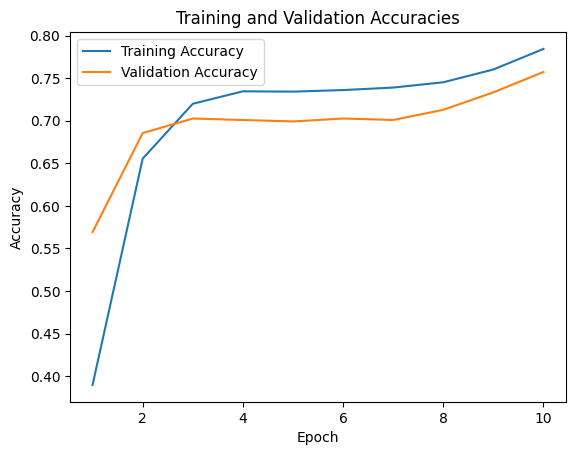

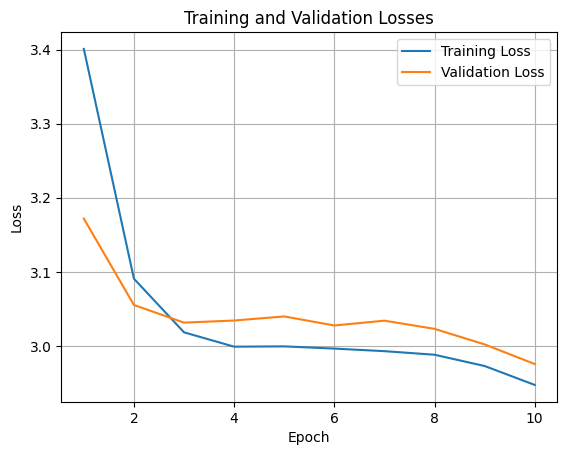

In [54]:
trainModel(tuned_convnext_large_model, 10)

In [55]:
evalModel(tuned_convnext_large_model, nn.CrossEntropyLoss())

Test Loss: 2.9720, Test Accuracy: 0.7594


## EfficientNetV2

### Models

#### Small


##### Load Model

In [56]:
default_weight_EfficientNetV2_small = models.EfficientNet_V2_S_Weights.DEFAULT
efficientnetv2_small_model = models.efficientnet_v2_s(weights=default_weight_EfficientNetV2_small)

In [57]:
for param in efficientnetv2_small_model.parameters():
    param.requires_grad = False

In [58]:
num_features = efficientnetv2_small_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_efficientnetv2_small_model = efficientnetv2_small_model


tuned_efficientnetv2_small_model.classifier = new_head

In [59]:
print(tuned_efficientnetv2_small_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

##### Training

Epoch [1/10], Train Loss: 3.5115, Train Accuracy: 0.2556, Val Loss: 3.3459, Val Accuracy: 0.4120
Epoch [2/10], Train Loss: 3.2555, Train Accuracy: 0.4921, Val Loss: 3.2088, Val Accuracy: 0.5487
Epoch [3/10], Train Loss: 3.1756, Train Accuracy: 0.5591, Val Loss: 3.1877, Val Accuracy: 0.5504
Epoch [4/10], Train Loss: 3.1218, Train Accuracy: 0.6170, Val Loss: 3.1365, Val Accuracy: 0.5983
Epoch [5/10], Train Loss: 3.0747, Train Accuracy: 0.6620, Val Loss: 3.0903, Val Accuracy: 0.6513
Epoch [6/10], Train Loss: 3.0467, Train Accuracy: 0.6913, Val Loss: 3.0801, Val Accuracy: 0.6598
Epoch [7/10], Train Loss: 3.0304, Train Accuracy: 0.7085, Val Loss: 3.0849, Val Accuracy: 0.6547
Epoch [8/10], Train Loss: 3.0217, Train Accuracy: 0.7155, Val Loss: 3.0715, Val Accuracy: 0.6564
Epoch [9/10], Train Loss: 2.9911, Train Accuracy: 0.7462, Val Loss: 3.0653, Val Accuracy: 0.6650
Epoch [10/10], Train Loss: 2.9764, Train Accuracy: 0.7580, Val Loss: 3.0378, Val Accuracy: 0.6940


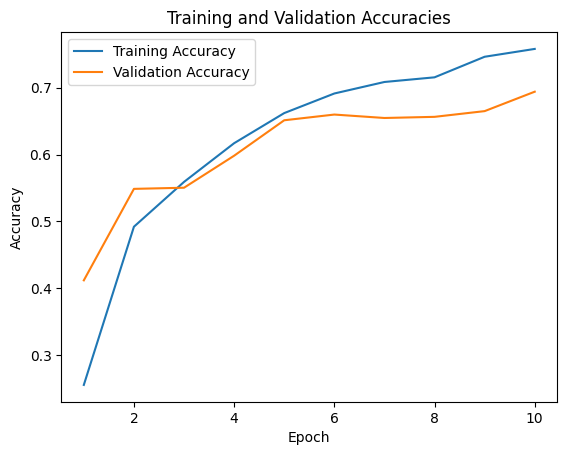

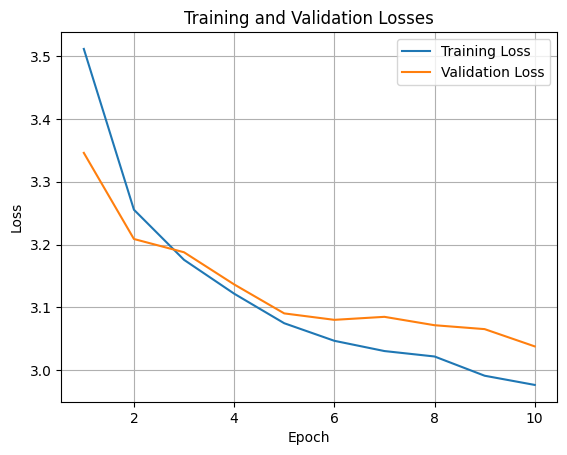

In [60]:
trainModel(tuned_efficientnetv2_small_model, 10)

In [61]:
evalModel(tuned_efficientnetv2_small_model, nn.CrossEntropyLoss())

Test Loss: 3.0553, Test Accuracy: 0.6809


#### Medium


##### Load Model

In [62]:
default_weight_EfficientNetV2_medium = models.EfficientNet_V2_M_Weights.DEFAULT
efficientnetv2_medium_model = models.efficientnet_v2_m(weights=default_weight_EfficientNetV2_medium)

In [63]:
for param in efficientnetv2_medium_model.parameters():
    param.requires_grad = False

In [64]:
num_features = efficientnetv2_medium_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_efficientnetv2_medium_model = efficientnetv2_medium_model

tuned_efficientnetv2_medium_model.classifier = new_head

In [65]:
print(tuned_efficientnetv2_medium_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

##### Training


Epoch [1/10], Train Loss: 3.4842, Train Accuracy: 0.3003, Val Loss: 3.3138, Val Accuracy: 0.4274
Epoch [2/10], Train Loss: 3.2317, Train Accuracy: 0.5174, Val Loss: 3.2113, Val Accuracy: 0.5402
Epoch [3/10], Train Loss: 3.1363, Train Accuracy: 0.6093, Val Loss: 3.1660, Val Accuracy: 0.5744
Epoch [4/10], Train Loss: 3.1091, Train Accuracy: 0.6276, Val Loss: 3.1563, Val Accuracy: 0.5812
Epoch [5/10], Train Loss: 3.0870, Train Accuracy: 0.6496, Val Loss: 3.1382, Val Accuracy: 0.6051
Epoch [6/10], Train Loss: 3.0543, Train Accuracy: 0.6840, Val Loss: 3.1156, Val Accuracy: 0.6239
Epoch [7/10], Train Loss: 3.0479, Train Accuracy: 0.6917, Val Loss: 3.1062, Val Accuracy: 0.6256
Epoch [8/10], Train Loss: 3.0424, Train Accuracy: 0.6910, Val Loss: 3.1142, Val Accuracy: 0.6222
Epoch [9/10], Train Loss: 3.0309, Train Accuracy: 0.7038, Val Loss: 3.0979, Val Accuracy: 0.6342
Epoch [10/10], Train Loss: 3.0213, Train Accuracy: 0.7148, Val Loss: 3.0692, Val Accuracy: 0.6667


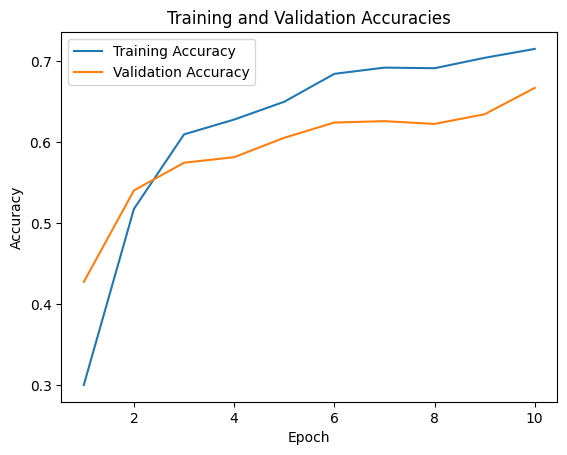

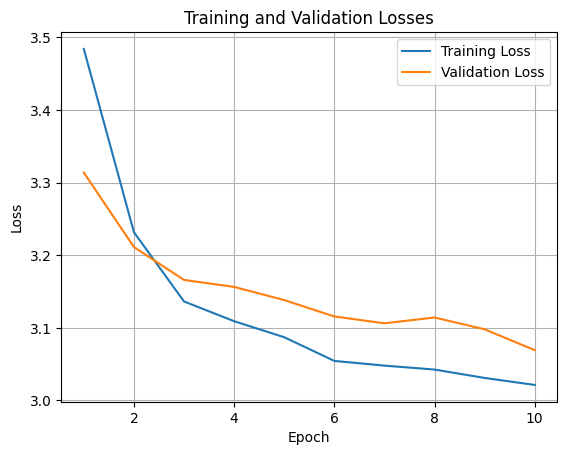

In [66]:
trainModel(tuned_efficientnetv2_medium_model, 10)

In [67]:
evalModel(tuned_efficientnetv2_medium_model, nn.CrossEntropyLoss())

Test Loss: 3.0813, Test Accuracy: 0.6553


#### Large 

##### Load Model

In [68]:
default_weight_EfficientNetV2_large = models.EfficientNet_V2_L_Weights.DEFAULT
efficientnetv2_large_model = models.efficientnet_v2_l(weights=default_weight_EfficientNetV2_large)

In [69]:
for param in efficientnetv2_large_model.parameters():
    param.requires_grad = False

In [70]:
num_features = efficientnetv2_large_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_efficientnetv2_large_model = efficientnetv2_large_model

tuned_efficientnetv2_large_model.classifier = new_head

In [71]:
print(tuned_efficientnetv2_large_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

##### Training

Epoch [1/10], Train Loss: 3.4695, Train Accuracy: 0.2951, Val Loss: 3.2936, Val Accuracy: 0.4684
Epoch [2/10], Train Loss: 3.2292, Train Accuracy: 0.5130, Val Loss: 3.1662, Val Accuracy: 0.5761
Epoch [3/10], Train Loss: 3.1315, Train Accuracy: 0.6111, Val Loss: 3.1208, Val Accuracy: 0.6154
Epoch [4/10], Train Loss: 3.0901, Train Accuracy: 0.6448, Val Loss: 3.0983, Val Accuracy: 0.6359
Epoch [5/10], Train Loss: 3.0700, Train Accuracy: 0.6690, Val Loss: 3.0737, Val Accuracy: 0.6632
Epoch [6/10], Train Loss: 3.0300, Train Accuracy: 0.7071, Val Loss: 3.0328, Val Accuracy: 0.7026
Epoch [7/10], Train Loss: 2.9959, Train Accuracy: 0.7389, Val Loss: 3.0139, Val Accuracy: 0.7179
Epoch [8/10], Train Loss: 2.9821, Train Accuracy: 0.7506, Val Loss: 3.0234, Val Accuracy: 0.7111
Epoch [9/10], Train Loss: 2.9799, Train Accuracy: 0.7528, Val Loss: 3.0339, Val Accuracy: 0.7009
Epoch [10/10], Train Loss: 2.9783, Train Accuracy: 0.7569, Val Loss: 3.0102, Val Accuracy: 0.7231


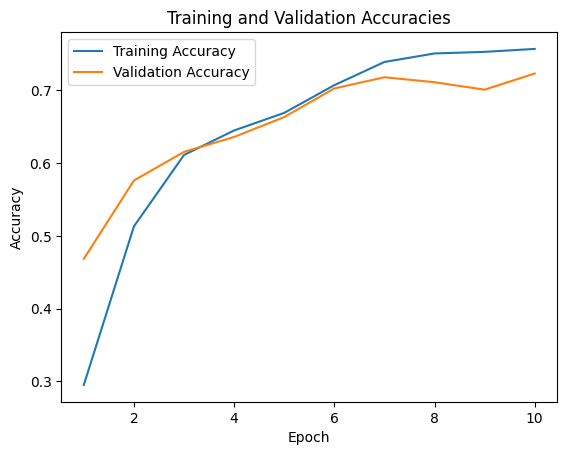

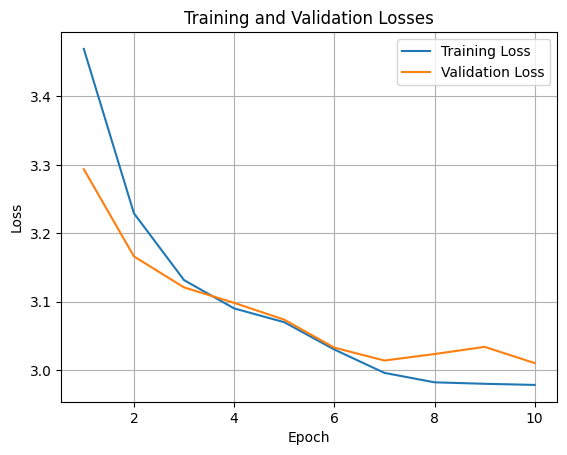

In [72]:
trainModel(tuned_efficientnetv2_large_model, 10)

In [73]:
evalModel(tuned_efficientnetv2_large_model, nn.CrossEntropyLoss())

Test Loss: 2.9821, Test Accuracy: 0.7543


## DenseNet

### Models

#### DenseNet121

##### Load Model

In [74]:
default_weight_densenet121 = models.DenseNet121_Weights.DEFAULT
densenet121_model = models.densenet121(weights=default_weight_densenet121)

In [75]:
for param in densenet121_model.parameters():
    param.requires_grad = False

In [76]:
num_features = densenet121_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet121_model = densenet121_model

tuned_densenet121_model.classifier = new_head

In [77]:
print(tuned_densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Training

Epoch [1/10], Train Loss: 3.5778, Train Accuracy: 0.1585, Val Loss: 3.4767, Val Accuracy: 0.2735
Epoch [2/10], Train Loss: 3.3249, Train Accuracy: 0.4288, Val Loss: 3.2642, Val Accuracy: 0.4769
Epoch [3/10], Train Loss: 3.2100, Train Accuracy: 0.5331, Val Loss: 3.2359, Val Accuracy: 0.5026
Epoch [4/10], Train Loss: 3.1847, Train Accuracy: 0.5514, Val Loss: 3.2375, Val Accuracy: 0.4991
Epoch [5/10], Train Loss: 3.1611, Train Accuracy: 0.5774, Val Loss: 3.2045, Val Accuracy: 0.5299
Epoch [6/10], Train Loss: 3.1513, Train Accuracy: 0.5815, Val Loss: 3.2183, Val Accuracy: 0.5128
Epoch [7/10], Train Loss: 3.1496, Train Accuracy: 0.5848, Val Loss: 3.2105, Val Accuracy: 0.5248
Epoch [8/10], Train Loss: 3.1512, Train Accuracy: 0.5837, Val Loss: 3.2018, Val Accuracy: 0.5316
Epoch [9/10], Train Loss: 3.1444, Train Accuracy: 0.5899, Val Loss: 3.2240, Val Accuracy: 0.5094
Epoch [10/10], Train Loss: 3.1408, Train Accuracy: 0.5895, Val Loss: 3.1929, Val Accuracy: 0.5385


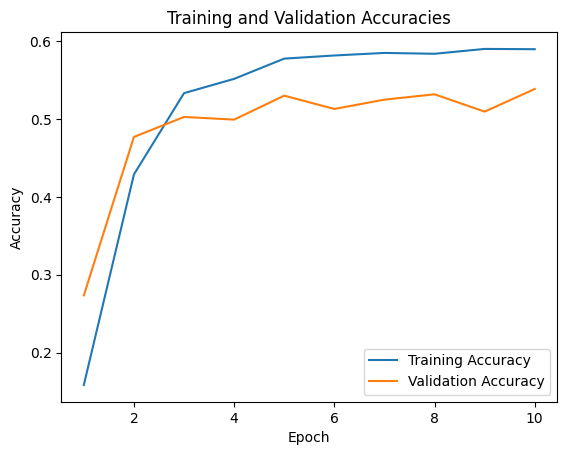

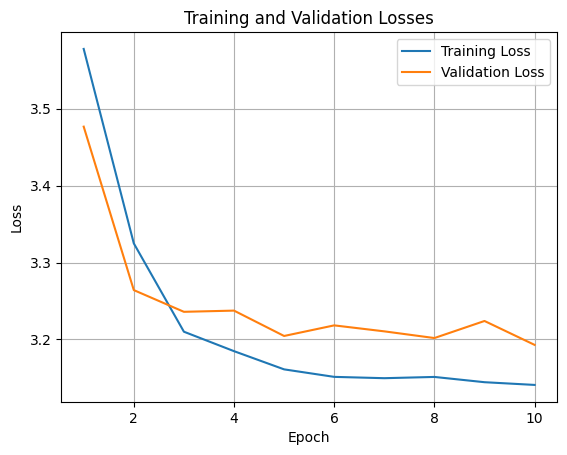

In [78]:
trainModel(tuned_densenet121_model, 10)

In [79]:
evalModel(tuned_densenet121_model, nn.CrossEntropyLoss())

Test Loss: 3.1645, Test Accuracy: 0.5648


#### DenseNet161

##### Load Model

In [80]:
default_weight_densenet161 = models.DenseNet161_Weights.DEFAULT
densenet161_model = models.densenet161(weights=default_weight_densenet161)

In [81]:
for param in densenet161_model.parameters():
    param.requires_grad = False

In [82]:
num_features = densenet161_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet161__model = densenet161_model

tuned_densenet161__model.classifier = new_head

In [83]:
print(tuned_densenet161__model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

##### Training

Epoch [1/10], Train Loss: 3.5609, Train Accuracy: 0.1816, Val Loss: 3.4319, Val Accuracy: 0.2991
Epoch [2/10], Train Loss: 3.3146, Train Accuracy: 0.4310, Val Loss: 3.2873, Val Accuracy: 0.4513
Epoch [3/10], Train Loss: 3.1997, Train Accuracy: 0.5416, Val Loss: 3.2084, Val Accuracy: 0.5299
Epoch [4/10], Train Loss: 3.1606, Train Accuracy: 0.5741, Val Loss: 3.1705, Val Accuracy: 0.5675
Epoch [5/10], Train Loss: 3.1299, Train Accuracy: 0.6089, Val Loss: 3.1553, Val Accuracy: 0.5863
Epoch [6/10], Train Loss: 3.1079, Train Accuracy: 0.6283, Val Loss: 3.1396, Val Accuracy: 0.5915
Epoch [7/10], Train Loss: 3.0971, Train Accuracy: 0.6360, Val Loss: 3.1318, Val Accuracy: 0.5983
Epoch [8/10], Train Loss: 3.0884, Train Accuracy: 0.6456, Val Loss: 3.1105, Val Accuracy: 0.6222
Epoch [9/10], Train Loss: 3.0690, Train Accuracy: 0.6646, Val Loss: 3.0922, Val Accuracy: 0.6410
Epoch [10/10], Train Loss: 3.0687, Train Accuracy: 0.6624, Val Loss: 3.1017, Val Accuracy: 0.6325


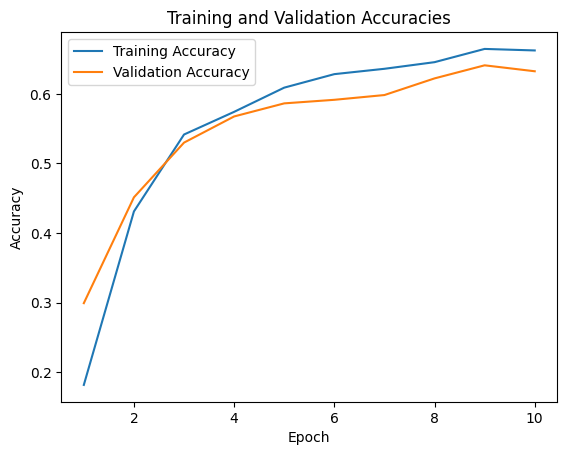

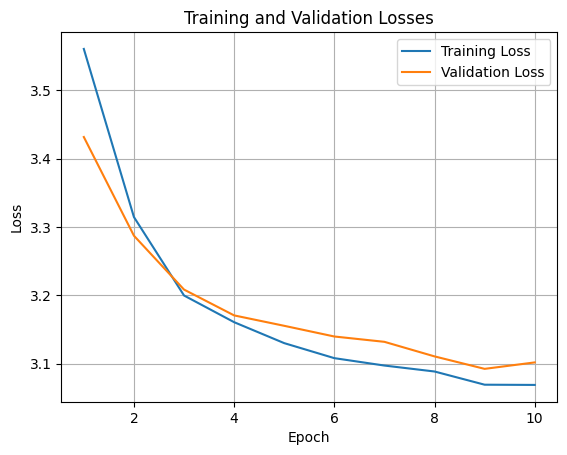

In [84]:
trainModel(tuned_densenet161__model, 10)

In [85]:
evalModel(tuned_densenet161__model, nn.CrossEntropyLoss())

Test Loss: 3.0905, Test Accuracy: 0.6433


#### DenseNet169

##### Load Model

In [86]:
default_weight_densenet169 = models.DenseNet169_Weights.DEFAULT
densenet169_model = models.densenet169(weights=default_weight_densenet169)

In [87]:
for param in densenet169_model.parameters():
    param.requires_grad = False

In [88]:
num_features = densenet169_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet169__model = densenet169_model

tuned_densenet169__model.classifier = new_head

In [89]:
print(tuned_densenet169__model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Training


Epoch [1/10], Train Loss: 3.5543, Train Accuracy: 0.1882, Val Loss: 3.3950, Val Accuracy: 0.3590
Epoch [2/10], Train Loss: 3.3376, Train Accuracy: 0.4072, Val Loss: 3.2789, Val Accuracy: 0.4786
Epoch [3/10], Train Loss: 3.1989, Train Accuracy: 0.5485, Val Loss: 3.1792, Val Accuracy: 0.5573
Epoch [4/10], Train Loss: 3.1517, Train Accuracy: 0.5840, Val Loss: 3.1784, Val Accuracy: 0.5556
Epoch [5/10], Train Loss: 3.1391, Train Accuracy: 0.5947, Val Loss: 3.1753, Val Accuracy: 0.5590
Epoch [6/10], Train Loss: 3.1362, Train Accuracy: 0.5990, Val Loss: 3.1657, Val Accuracy: 0.5641
Epoch [7/10], Train Loss: 3.1222, Train Accuracy: 0.6111, Val Loss: 3.1360, Val Accuracy: 0.5983
Epoch [8/10], Train Loss: 3.1073, Train Accuracy: 0.6265, Val Loss: 3.1257, Val Accuracy: 0.6085
Epoch [9/10], Train Loss: 3.0942, Train Accuracy: 0.6401, Val Loss: 3.1455, Val Accuracy: 0.5915
Epoch [10/10], Train Loss: 3.0834, Train Accuracy: 0.6492, Val Loss: 3.1063, Val Accuracy: 0.6256


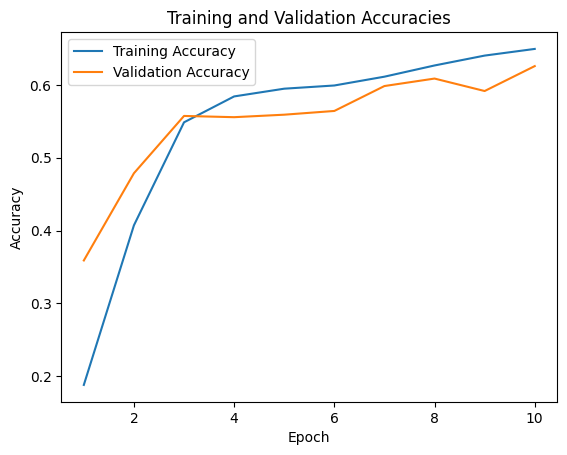

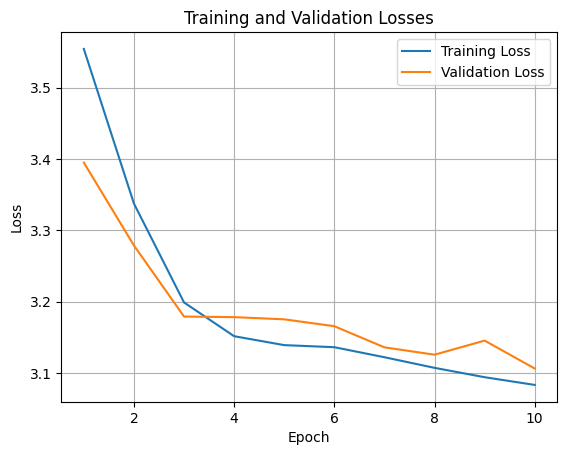

In [90]:
trainModel(tuned_densenet169__model, 10)

In [91]:
evalModel(tuned_densenet169__model, nn.CrossEntropyLoss())

Test Loss: 3.1216, Test Accuracy: 0.6109


#### DenseNet201

##### Load Model

In [92]:
default_weight_denseNet201 = models.DenseNet201_Weights.DEFAULT
densenet201_model = models.densenet201(weights=default_weight_denseNet201)

In [93]:
for param in densenet201_model.parameters():
    param.requires_grad = False

In [94]:
num_features = densenet201_model.classifier.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_densenet201__model = densenet201_model

tuned_densenet201__model.classifier = new_head

In [95]:
print(tuned_densenet201__model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

##### Training

Epoch [1/10], Train Loss: 3.5659, Train Accuracy: 0.1798, Val Loss: 3.4178, Val Accuracy: 0.3145
Epoch [2/10], Train Loss: 3.3694, Train Accuracy: 0.3742, Val Loss: 3.3510, Val Accuracy: 0.3812
Epoch [3/10], Train Loss: 3.2884, Train Accuracy: 0.4478, Val Loss: 3.2777, Val Accuracy: 0.4564
Epoch [4/10], Train Loss: 3.2292, Train Accuracy: 0.5090, Val Loss: 3.2379, Val Accuracy: 0.4957
Epoch [5/10], Train Loss: 3.1919, Train Accuracy: 0.5452, Val Loss: 3.2172, Val Accuracy: 0.5111
Epoch [6/10], Train Loss: 3.1682, Train Accuracy: 0.5646, Val Loss: 3.1838, Val Accuracy: 0.5504
Epoch [7/10], Train Loss: 3.1513, Train Accuracy: 0.5826, Val Loss: 3.1795, Val Accuracy: 0.5556
Epoch [8/10], Train Loss: 3.1134, Train Accuracy: 0.6232, Val Loss: 3.1497, Val Accuracy: 0.5880
Epoch [9/10], Train Loss: 3.0956, Train Accuracy: 0.6404, Val Loss: 3.1273, Val Accuracy: 0.6034
Epoch [10/10], Train Loss: 3.0687, Train Accuracy: 0.6661, Val Loss: 3.0945, Val Accuracy: 0.6376


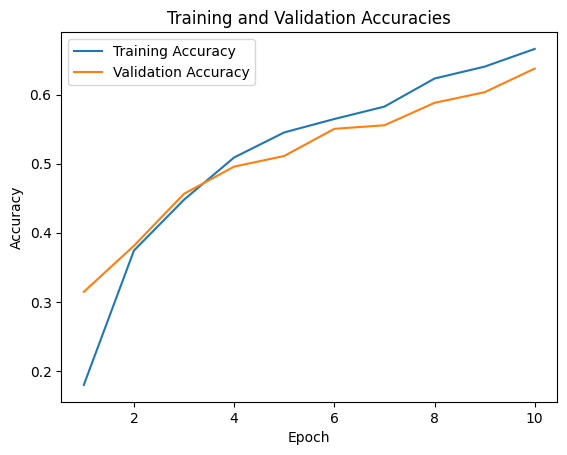

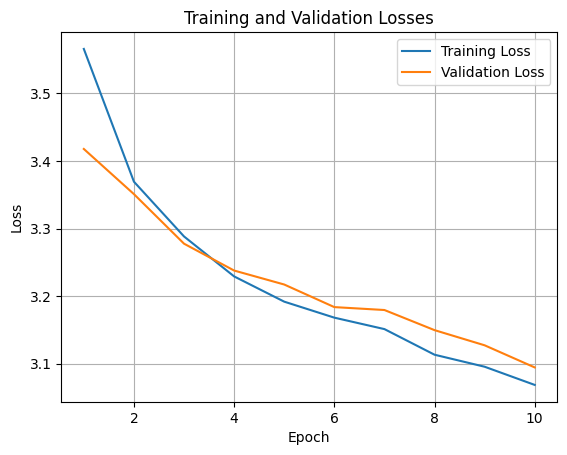

In [96]:
trainModel(tuned_densenet201__model, 10)

In [97]:
evalModel(tuned_densenet201__model, nn.CrossEntropyLoss())

Test Loss: 3.0811, Test Accuracy: 0.6519


## MaxVit

### Load Model

In [98]:
default_weight_maxvit = models.MaxVit_T_Weights.DEFAULT
maxvit_model = models.maxvit_t(weights=default_weight_maxvit)

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [99]:
for param in maxvit_model.parameters():
    param.requires_grad = False

In [100]:
num_features = maxvit_model.classifier[5].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_maxvit_model = maxvit_model

tuned_maxvit_model.classifier[5] = new_head

In [101]:
print(tuned_maxvit_model)

MaxVit(
  (stem): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (blocks): ModuleList(
    (0): MaxVitBlock(
      (layers): ModuleList(
        (0): MaxVitLayer(
          (layers): Sequential(
            (MBconv): MBConv(
              (proj): Sequential(
                (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
                (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              )
              (stochastic_depth): Identity()
              (layers): Sequential(
                (pre_norm): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
                (conv_a): Conv2dNormActivation(
           

### Training

Epoch [1/10], Train Loss: 3.4963, Train Accuracy: 0.2710, Val Loss: 3.3157, Val Accuracy: 0.4410
Epoch [2/10], Train Loss: 3.2291, Train Accuracy: 0.5108, Val Loss: 3.2396, Val Accuracy: 0.5111
Epoch [3/10], Train Loss: 3.1698, Train Accuracy: 0.5683, Val Loss: 3.2046, Val Accuracy: 0.5350
Epoch [4/10], Train Loss: 3.1160, Train Accuracy: 0.6203, Val Loss: 3.1556, Val Accuracy: 0.5829
Epoch [5/10], Train Loss: 3.0895, Train Accuracy: 0.6463, Val Loss: 3.1543, Val Accuracy: 0.5812
Epoch [6/10], Train Loss: 3.0694, Train Accuracy: 0.6657, Val Loss: 3.1379, Val Accuracy: 0.5983
Epoch [7/10], Train Loss: 3.0345, Train Accuracy: 0.6994, Val Loss: 3.1139, Val Accuracy: 0.6222
Epoch [8/10], Train Loss: 3.0182, Train Accuracy: 0.7188, Val Loss: 3.1099, Val Accuracy: 0.6239
Epoch [9/10], Train Loss: 3.0043, Train Accuracy: 0.7320, Val Loss: 3.0897, Val Accuracy: 0.6410
Epoch [10/10], Train Loss: 2.9845, Train Accuracy: 0.7488, Val Loss: 3.0927, Val Accuracy: 0.6427


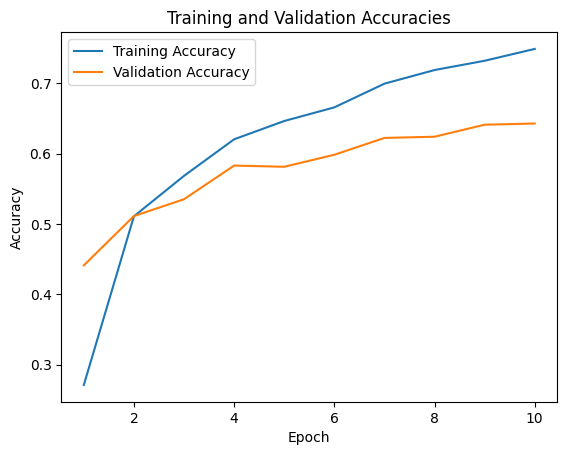

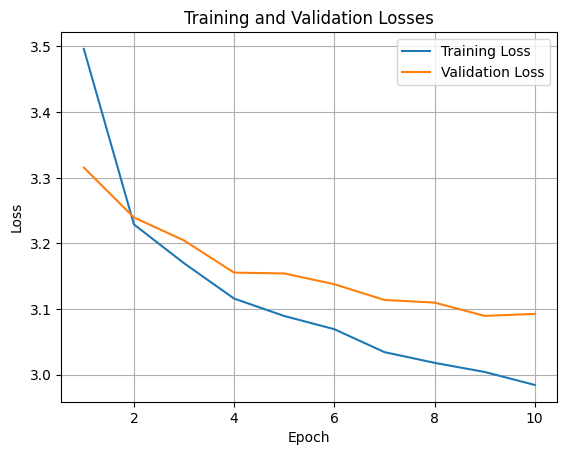

In [102]:
trainModel(tuned_maxvit_model, 10)

In [103]:
evalModel(tuned_maxvit_model, nn.CrossEntropyLoss())

Test Loss: 3.0774, Test Accuracy: 0.6587


## MNASNet

### Models

#### MNASNET0_5

##### Load Model

In [104]:
default_weight_mnasnet0_5 = models.MNASNet0_5_Weights.DEFAULT
mnasnet0_5_model = models.mnasnet0_5(weights=default_weight_mnasnet0_5)

In [105]:
for param in mnasnet0_5_model.parameters():
    param.requires_grad = False

In [106]:
num_features = mnasnet0_5_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet0_5_model = mnasnet0_5_model

tuned_mnasnet0_5_model.classifier = new_head

In [107]:
print(tuned_mnasnet0_5_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(24, 24,

##### Training

Epoch [1/10], Train Loss: 3.6219, Train Accuracy: 0.1164, Val Loss: 3.5082, Val Accuracy: 0.2838
Epoch [2/10], Train Loss: 3.3426, Train Accuracy: 0.4277, Val Loss: 3.2605, Val Accuracy: 0.5077
Epoch [3/10], Train Loss: 3.2005, Train Accuracy: 0.5471, Val Loss: 3.2016, Val Accuracy: 0.5607
Epoch [4/10], Train Loss: 3.1429, Train Accuracy: 0.6038, Val Loss: 3.1545, Val Accuracy: 0.6000
Epoch [5/10], Train Loss: 3.1060, Train Accuracy: 0.6371, Val Loss: 3.1397, Val Accuracy: 0.6120
Epoch [6/10], Train Loss: 3.0697, Train Accuracy: 0.6723, Val Loss: 3.1156, Val Accuracy: 0.6308
Epoch [7/10], Train Loss: 3.0460, Train Accuracy: 0.6957, Val Loss: 3.1144, Val Accuracy: 0.6256
Epoch [8/10], Train Loss: 3.0215, Train Accuracy: 0.7199, Val Loss: 3.0910, Val Accuracy: 0.6513
Epoch [9/10], Train Loss: 3.0069, Train Accuracy: 0.7316, Val Loss: 3.0677, Val Accuracy: 0.6735
Epoch [10/10], Train Loss: 2.9919, Train Accuracy: 0.7477, Val Loss: 3.0685, Val Accuracy: 0.6752


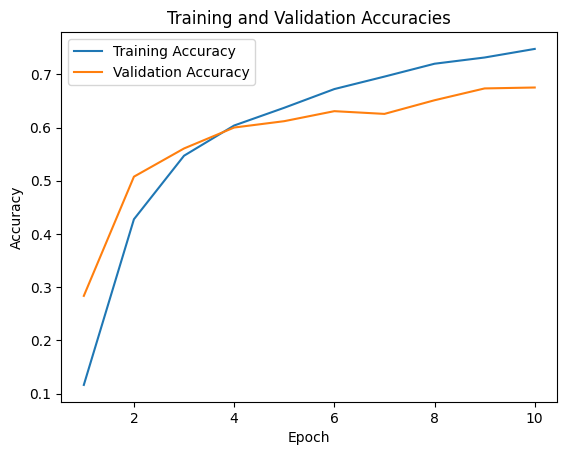

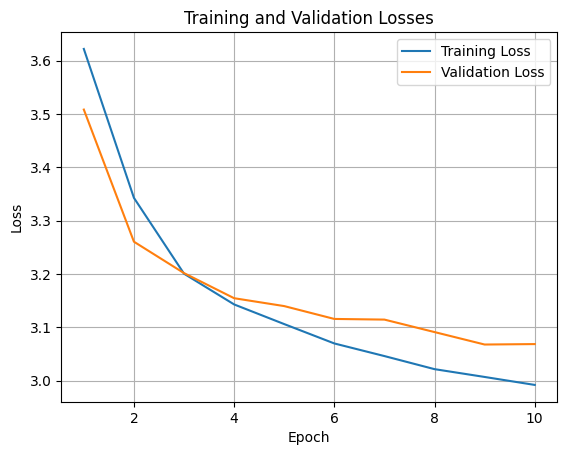

In [108]:
trainModel(tuned_mnasnet0_5_model, 10)

In [109]:
evalModel(tuned_mnasnet0_5_model, nn.CrossEntropyLoss())

Test Loss: 3.0697, Test Accuracy: 0.6758


#### MNASNET0_75

##### Load Model

In [110]:
default_weight_mnasnet0_75 = models.MNASNet0_75_Weights.DEFAULT
mnasnet0_75_model = models.mnasnet0_75(weights=default_weight_mnasnet0_75)

In [111]:
for param in mnasnet0_75_model.parameters():
    param.requires_grad = False

In [112]:
num_features = mnasnet0_75_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet0_75_model = mnasnet0_75_model

tuned_mnasnet0_75_model.classifier = new_head

In [113]:
print(tuned_mnasnet0_75_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

##### Training

Epoch [1/10], Train Loss: 3.5235, Train Accuracy: 0.2351, Val Loss: 3.3470, Val Accuracy: 0.4205
Epoch [2/10], Train Loss: 3.1885, Train Accuracy: 0.5679, Val Loss: 3.1628, Val Accuracy: 0.5829
Epoch [3/10], Train Loss: 3.0765, Train Accuracy: 0.6657, Val Loss: 3.1071, Val Accuracy: 0.6427
Epoch [4/10], Train Loss: 3.0596, Train Accuracy: 0.6785, Val Loss: 3.0995, Val Accuracy: 0.6444
Epoch [5/10], Train Loss: 3.0141, Train Accuracy: 0.7283, Val Loss: 3.0867, Val Accuracy: 0.6615
Epoch [6/10], Train Loss: 2.9865, Train Accuracy: 0.7532, Val Loss: 3.0661, Val Accuracy: 0.6718
Epoch [7/10], Train Loss: 2.9751, Train Accuracy: 0.7613, Val Loss: 3.0595, Val Accuracy: 0.6786
Epoch [8/10], Train Loss: 2.9656, Train Accuracy: 0.7700, Val Loss: 3.0703, Val Accuracy: 0.6684
Epoch [9/10], Train Loss: 2.9576, Train Accuracy: 0.7766, Val Loss: 3.0344, Val Accuracy: 0.7043
Epoch [10/10], Train Loss: 2.9520, Train Accuracy: 0.7840, Val Loss: 3.0345, Val Accuracy: 0.6974


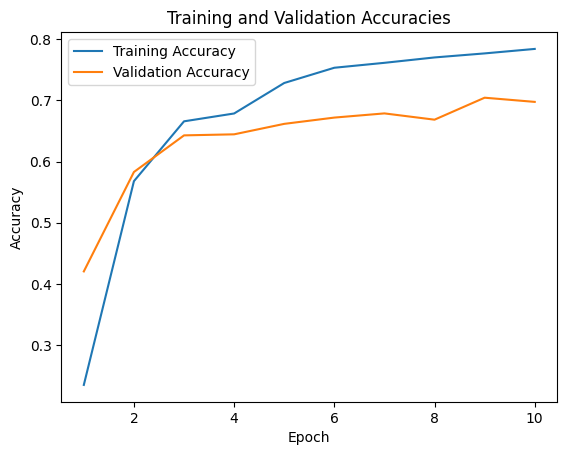

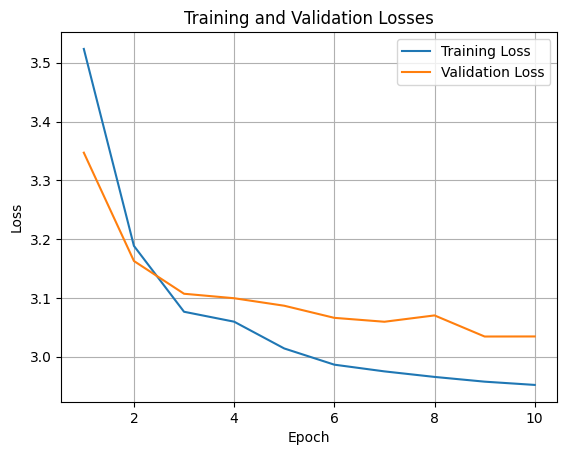

In [114]:
trainModel(tuned_mnasnet0_75_model, 10)

In [115]:
evalModel(tuned_mnasnet0_75_model, nn.CrossEntropyLoss())

Test Loss: 3.0377, Test Accuracy: 0.6962


#### MNASNET1_0

##### Load Model

In [116]:
default_weight_mnasnet1_0 = models.MNASNet1_0_Weights.DEFAULT
mnasnet1_0_model = models.mnasnet1_0(weights=default_weight_mnasnet1_0)

In [117]:
for param in mnasnet1_0_model.parameters():
    param.requires_grad = False

In [118]:
num_features = mnasnet1_0_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet1_0_model = mnasnet1_0_model

tuned_mnasnet1_0_model.classifier = new_head

In [119]:
print(tuned_mnasnet1_0_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

##### Training

Epoch [1/10], Train Loss: 3.5783, Train Accuracy: 0.1681, Val Loss: 3.4671, Val Accuracy: 0.2803
Epoch [2/10], Train Loss: 3.3497, Train Accuracy: 0.3936, Val Loss: 3.3546, Val Accuracy: 0.3761
Epoch [3/10], Train Loss: 3.2890, Train Accuracy: 0.4460, Val Loss: 3.3104, Val Accuracy: 0.4222
Epoch [4/10], Train Loss: 3.2458, Train Accuracy: 0.4914, Val Loss: 3.2658, Val Accuracy: 0.4752
Epoch [5/10], Train Loss: 3.2117, Train Accuracy: 0.5233, Val Loss: 3.2493, Val Accuracy: 0.4855
Epoch [6/10], Train Loss: 3.1828, Train Accuracy: 0.5518, Val Loss: 3.2286, Val Accuracy: 0.5043
Epoch [7/10], Train Loss: 3.1676, Train Accuracy: 0.5683, Val Loss: 3.2305, Val Accuracy: 0.4991
Epoch [8/10], Train Loss: 3.1531, Train Accuracy: 0.5800, Val Loss: 3.2085, Val Accuracy: 0.5231
Epoch [9/10], Train Loss: 3.1413, Train Accuracy: 0.5914, Val Loss: 3.1731, Val Accuracy: 0.5624
Epoch [10/10], Train Loss: 3.1218, Train Accuracy: 0.6133, Val Loss: 3.1544, Val Accuracy: 0.5761


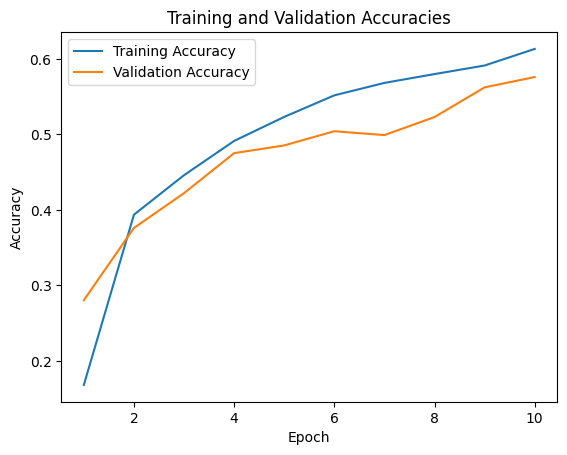

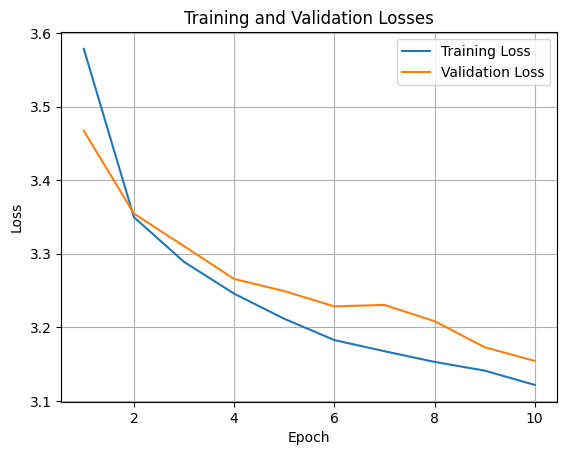

In [120]:
trainModel(tuned_mnasnet1_0_model, 10)

In [121]:
evalModel(tuned_mnasnet1_0_model, nn.CrossEntropyLoss())

Test Loss: 3.1565, Test Accuracy: 0.5768


#### MNASNET1_3

##### Load Model

In [122]:
default_weight_mnasnet1_3 = models.MNASNet1_3_Weights.DEFAULT
mnasnet1_3_model = models.mnasnet1_3(weights=default_weight_mnasnet1_3)

In [123]:
for param in mnasnet1_3_model.parameters():
    param.requires_grad = False

In [124]:
num_features = mnasnet1_3_model.classifier[1].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_mnasnet1_3_model = mnasnet1_3_model

tuned_mnasnet1_3_model.classifier = new_head

In [125]:
print(tuned_mnasnet1_3_model)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(24, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(72, 

##### Training

Epoch [1/10], Train Loss: 3.5256, Train Accuracy: 0.2234, Val Loss: 3.3411, Val Accuracy: 0.4274
Epoch [2/10], Train Loss: 3.2426, Train Accuracy: 0.5053, Val Loss: 3.2136, Val Accuracy: 0.5368
Epoch [3/10], Train Loss: 3.1626, Train Accuracy: 0.5767, Val Loss: 3.2011, Val Accuracy: 0.5487
Epoch [4/10], Train Loss: 3.1415, Train Accuracy: 0.5965, Val Loss: 3.1659, Val Accuracy: 0.5726
Epoch [5/10], Train Loss: 3.1159, Train Accuracy: 0.6210, Val Loss: 3.1306, Val Accuracy: 0.6137
Epoch [6/10], Train Loss: 3.0982, Train Accuracy: 0.6360, Val Loss: 3.1297, Val Accuracy: 0.6051
Epoch [7/10], Train Loss: 3.0957, Train Accuracy: 0.6375, Val Loss: 3.1335, Val Accuracy: 0.6051
Epoch [8/10], Train Loss: 3.0850, Train Accuracy: 0.6507, Val Loss: 3.1224, Val Accuracy: 0.6085
Epoch [9/10], Train Loss: 3.0662, Train Accuracy: 0.6683, Val Loss: 3.1317, Val Accuracy: 0.6051
Epoch [10/10], Train Loss: 3.0636, Train Accuracy: 0.6697, Val Loss: 3.1289, Val Accuracy: 0.6000


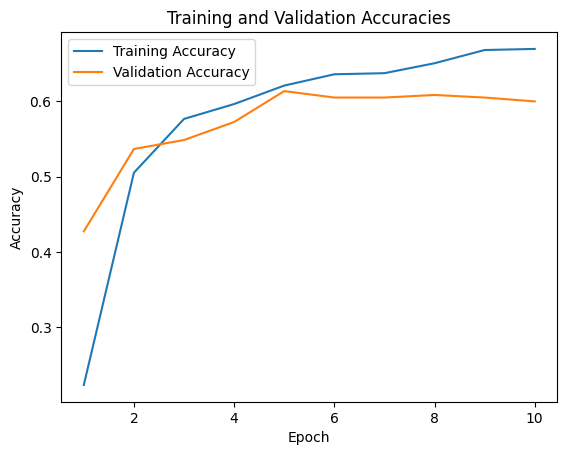

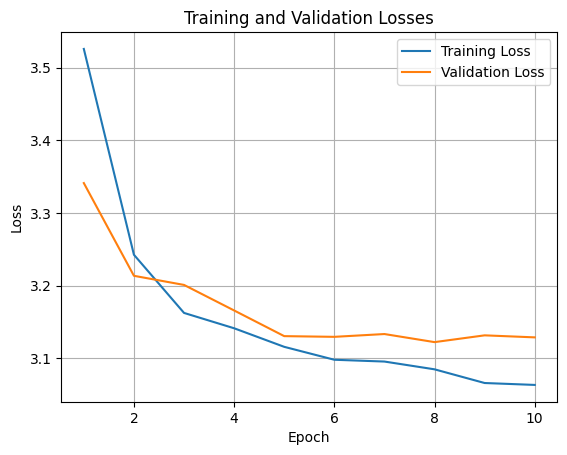

In [126]:
trainModel(tuned_mnasnet1_3_model, 10)

In [127]:
evalModel(tuned_mnasnet1_3_model, nn.CrossEntropyLoss())

Test Loss: 3.1548, Test Accuracy: 0.5768


## ShuffleNet V2

### Models

#### ShuffleNetV2_x0_5

##### Load Model

In [128]:
default_weight_shuffleNetV2_x0_5 = models.ShuffleNet_V2_X0_5_Weights.DEFAULT
shufflenetv2_x0_5_model = models.shufflenet_v2_x0_5(weights=default_weight_shuffleNetV2_x0_5)

In [129]:
for param in shufflenetv2_x0_5_model.parameters():
    param.requires_grad = False

In [130]:
num_features = shufflenetv2_x0_5_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x0_5_model = shufflenetv2_x0_5_model

tuned_shufflenetv2_x0_5_model.fc = new_head

In [131]:
print(tuned_shufflenetv2_x0_5_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

##### Training

Epoch [1/10], Train Loss: 3.6687, Train Accuracy: 0.0626, Val Loss: 3.6184, Val Accuracy: 0.1145
Epoch [2/10], Train Loss: 3.5386, Train Accuracy: 0.2069, Val Loss: 3.4710, Val Accuracy: 0.2718
Epoch [3/10], Train Loss: 3.4160, Train Accuracy: 0.3413, Val Loss: 3.3850, Val Accuracy: 0.3897
Epoch [4/10], Train Loss: 3.3338, Train Accuracy: 0.4262, Val Loss: 3.3039, Val Accuracy: 0.4496
Epoch [5/10], Train Loss: 3.2756, Train Accuracy: 0.4760, Val Loss: 3.2669, Val Accuracy: 0.4821
Epoch [6/10], Train Loss: 3.2438, Train Accuracy: 0.5053, Val Loss: 3.2310, Val Accuracy: 0.5179
Epoch [7/10], Train Loss: 3.2236, Train Accuracy: 0.5233, Val Loss: 3.2218, Val Accuracy: 0.5214
Epoch [8/10], Train Loss: 3.2012, Train Accuracy: 0.5438, Val Loss: 3.2142, Val Accuracy: 0.5333
Epoch [9/10], Train Loss: 3.1838, Train Accuracy: 0.5577, Val Loss: 3.2027, Val Accuracy: 0.5350
Epoch [10/10], Train Loss: 3.1688, Train Accuracy: 0.5716, Val Loss: 3.2020, Val Accuracy: 0.5316


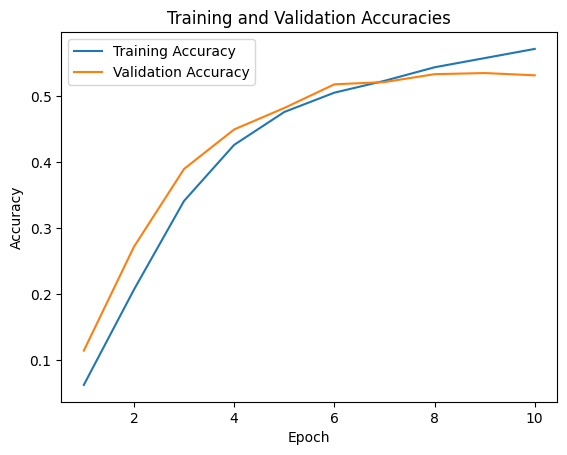

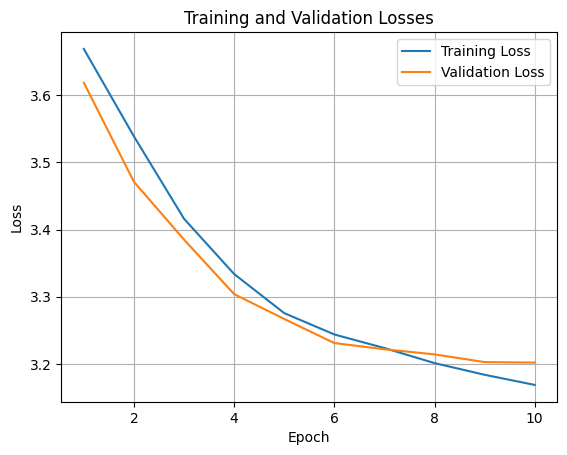

In [132]:
trainModel(tuned_shufflenetv2_x0_5_model, 10)

In [133]:
evalModel(tuned_shufflenetv2_x0_5_model, nn.CrossEntropyLoss())

Test Loss: 3.1954, Test Accuracy: 0.5461


#### ShuffleNetV2_x1_0

##### Load Model

In [134]:
default_weight_shuffleNetV2_x1_0 = models.ShuffleNet_V2_X1_0_Weights.DEFAULT
shufflenetv2_x1_0_model = models.shufflenet_v2_x1_0(weights=default_weight_shuffleNetV2_x1_0)

In [135]:
for param in shufflenetv2_x1_0_model.parameters():
    param.requires_grad = False

In [136]:
num_features = shufflenetv2_x1_0_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x1_0_model = shufflenetv2_x1_0_model

tuned_shufflenetv2_x1_0_model.fc = new_head

In [137]:
print(tuned_shufflenetv2_x1_0_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

##### Training

Epoch [1/10], Train Loss: 3.6715, Train Accuracy: 0.0483, Val Loss: 3.6407, Val Accuracy: 0.0803
Epoch [2/10], Train Loss: 3.5715, Train Accuracy: 0.1842, Val Loss: 3.4949, Val Accuracy: 0.2598
Epoch [3/10], Train Loss: 3.4282, Train Accuracy: 0.3332, Val Loss: 3.3817, Val Accuracy: 0.3744
Epoch [4/10], Train Loss: 3.3394, Train Accuracy: 0.4178, Val Loss: 3.3280, Val Accuracy: 0.4205
Epoch [5/10], Train Loss: 3.2826, Train Accuracy: 0.4691, Val Loss: 3.2877, Val Accuracy: 0.4650
Epoch [6/10], Train Loss: 3.2484, Train Accuracy: 0.4998, Val Loss: 3.2445, Val Accuracy: 0.5094
Epoch [7/10], Train Loss: 3.2062, Train Accuracy: 0.5412, Val Loss: 3.2095, Val Accuracy: 0.5368
Epoch [8/10], Train Loss: 3.1877, Train Accuracy: 0.5569, Val Loss: 3.2227, Val Accuracy: 0.5162
Epoch [9/10], Train Loss: 3.1684, Train Accuracy: 0.5745, Val Loss: 3.2061, Val Accuracy: 0.5282
Epoch [10/10], Train Loss: 3.1622, Train Accuracy: 0.5763, Val Loss: 3.2175, Val Accuracy: 0.5162


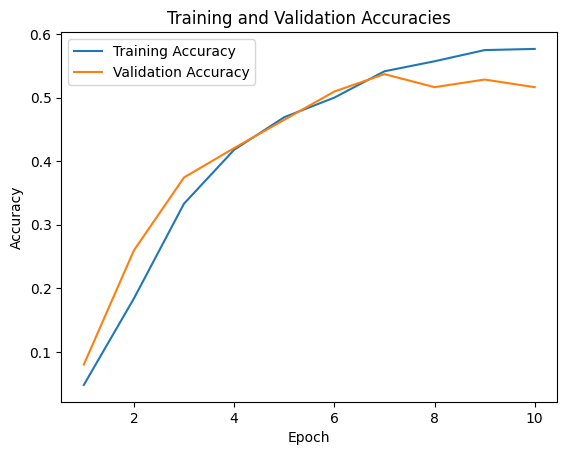

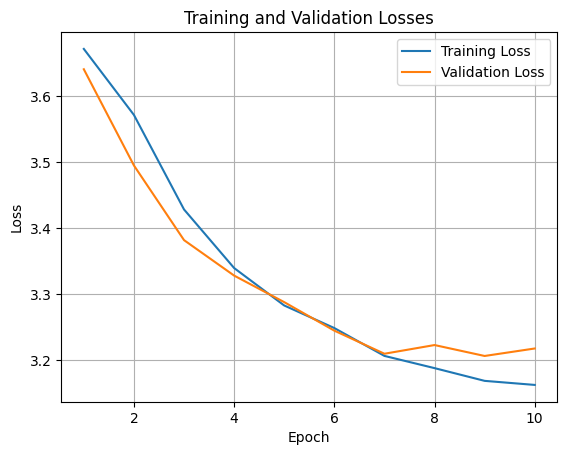

In [138]:
trainModel(tuned_shufflenetv2_x1_0_model, 10)

In [139]:
evalModel(tuned_shufflenetv2_x1_0_model, nn.CrossEntropyLoss())

Test Loss: 3.1951, Test Accuracy: 0.5444


#### ShuffleNetV2_x1_5

##### Load Model

In [140]:
default_weight_shuffleNetV2_x1_5 = models.ShuffleNet_V2_X1_5_Weights.DEFAULT
shufflenetv2_x1_5_model = models.shufflenet_v2_x1_5(weights=default_weight_shuffleNetV2_x1_5)

In [141]:
for param in shufflenetv2_x1_5_model.parameters():
    param.requires_grad = False

In [142]:
num_features = shufflenetv2_x1_5_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x1_5_model = shufflenetv2_x1_5_model

tuned_shufflenetv2_x1_5_model.fc = new_head

##### Training

Epoch [1/10], Train Loss: 3.5325, Train Accuracy: 0.2124, Val Loss: 3.3779, Val Accuracy: 0.3761
Epoch [2/10], Train Loss: 3.2409, Train Accuracy: 0.5170, Val Loss: 3.1922, Val Accuracy: 0.5538
Epoch [3/10], Train Loss: 3.1488, Train Accuracy: 0.5895, Val Loss: 3.1587, Val Accuracy: 0.5829
Epoch [4/10], Train Loss: 3.1132, Train Accuracy: 0.6247, Val Loss: 3.1326, Val Accuracy: 0.6103
Epoch [5/10], Train Loss: 3.0728, Train Accuracy: 0.6664, Val Loss: 3.1076, Val Accuracy: 0.6291
Epoch [6/10], Train Loss: 3.0526, Train Accuracy: 0.6840, Val Loss: 3.0931, Val Accuracy: 0.6496
Epoch [7/10], Train Loss: 3.0483, Train Accuracy: 0.6858, Val Loss: 3.0985, Val Accuracy: 0.6359
Epoch [8/10], Train Loss: 3.0432, Train Accuracy: 0.6917, Val Loss: 3.1044, Val Accuracy: 0.6274
Epoch [9/10], Train Loss: 3.0372, Train Accuracy: 0.6979, Val Loss: 3.0633, Val Accuracy: 0.6752
Epoch [10/10], Train Loss: 3.0370, Train Accuracy: 0.6964, Val Loss: 3.0732, Val Accuracy: 0.6598


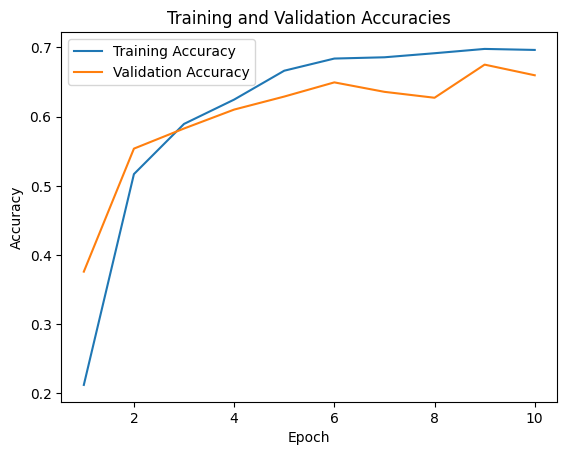

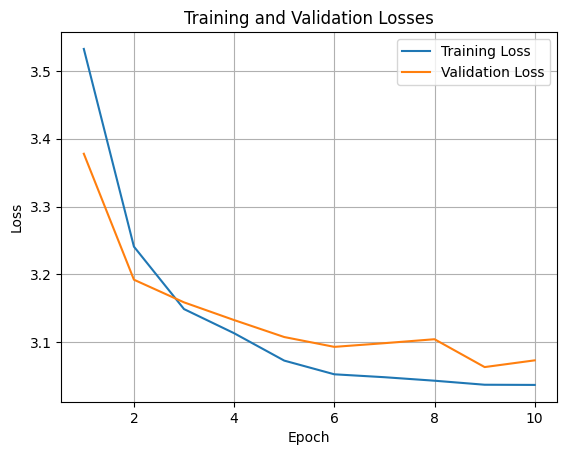

In [143]:
trainModel(tuned_shufflenetv2_x1_5_model, 10)

In [144]:
evalModel(tuned_shufflenetv2_x1_5_model, nn.CrossEntropyLoss())

Test Loss: 3.0522, Test Accuracy: 0.6809


#### ShuffleNetV2_x2_0

##### Load Model

In [145]:
default_weight_shuffleNetV2_x2_0 = models.ShuffleNet_V2_X2_0_Weights.DEFAULT
shufflenetv2_x2_0_model = models.shufflenet_v2_x2_0(weights=default_weight_shuffleNetV2_x2_0)

In [146]:
for param in shufflenetv2_x2_0_model.parameters():
    param.requires_grad = False

In [147]:
num_features = shufflenetv2_x2_0_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_shufflenetv2_x2_0_model = shufflenetv2_x2_0_model

tuned_shufflenetv2_x2_0_model.fc = new_head

In [148]:
print(tuned_shufflenetv2_x2_0_model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_runn

##### Training

Epoch [1/10], Train Loss: 3.5191, Train Accuracy: 0.2332, Val Loss: 3.3391, Val Accuracy: 0.4222
Epoch [2/10], Train Loss: 3.2027, Train Accuracy: 0.5467, Val Loss: 3.1837, Val Accuracy: 0.5624
Epoch [3/10], Train Loss: 3.1187, Train Accuracy: 0.6188, Val Loss: 3.1632, Val Accuracy: 0.5778
Epoch [4/10], Train Loss: 3.1017, Train Accuracy: 0.6335, Val Loss: 3.1422, Val Accuracy: 0.5897
Epoch [5/10], Train Loss: 3.0875, Train Accuracy: 0.6463, Val Loss: 3.1212, Val Accuracy: 0.6154
Epoch [6/10], Train Loss: 3.0681, Train Accuracy: 0.6675, Val Loss: 3.1115, Val Accuracy: 0.6239
Epoch [7/10], Train Loss: 3.0682, Train Accuracy: 0.6653, Val Loss: 3.1230, Val Accuracy: 0.6120
Epoch [8/10], Train Loss: 3.0570, Train Accuracy: 0.6752, Val Loss: 3.1281, Val Accuracy: 0.6068
Epoch [9/10], Train Loss: 3.0520, Train Accuracy: 0.6800, Val Loss: 3.1240, Val Accuracy: 0.6103
Epoch [10/10], Train Loss: 3.0425, Train Accuracy: 0.6910, Val Loss: 3.1135, Val Accuracy: 0.6188


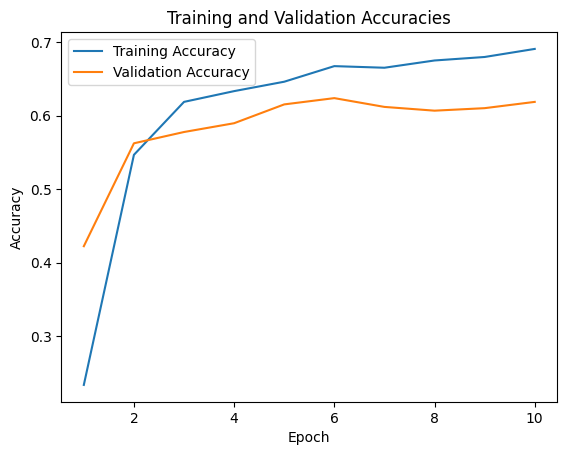

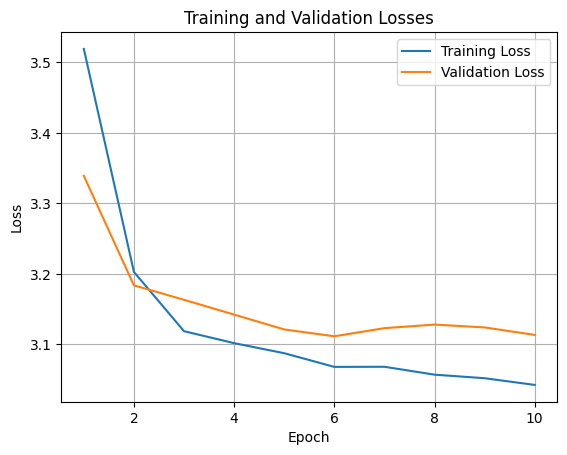

In [149]:
trainModel(tuned_shufflenetv2_x2_0_model, 10)

In [150]:
evalModel(tuned_shufflenetv2_x2_0_model, nn.CrossEntropyLoss())

Test Loss: 3.0911, Test Accuracy: 0.6416


## SqueezeNet

### Models

#### squeezenet1_0

##### Load Model

In [151]:
default_weight_squeezenet1_0 = models.SqueezeNet1_0_Weights.DEFAULT
squeezenet1_0_model = models.squeezenet1_0(weights=default_weight_squeezenet1_0)

In [152]:
for param in squeezenet1_0_model.parameters():
    param.requires_grad = False

In [153]:
tuned_squeezenet1_0_model = squeezenet1_0_model

new_head = nn.Sequential(
    nn.Dropout(p=0.2),  # Dropout layer with 0.2 probability
    nn.Conv2d(512, 40, kernel_size=(1, 1), stride=(1, 1)),  # Convolutional layer with 40 filters
    nn.ReLU(inplace=True),  # ReLU activation
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Adaptive average pooling layer
    nn.Flatten(),  # Flatten layer
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_squeezenet1_0_model.classifier = new_head

In [154]:
print(tuned_squeezenet1_0_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

##### Training

Epoch [1/10], Train Loss: 3.4543, Train Accuracy: 0.3142, Val Loss: 3.2935, Val Accuracy: 0.4735
Epoch [2/10], Train Loss: 3.1887, Train Accuracy: 0.5756, Val Loss: 3.1848, Val Accuracy: 0.5675
Epoch [3/10], Train Loss: 3.0797, Train Accuracy: 0.6737, Val Loss: 3.1299, Val Accuracy: 0.6342
Epoch [4/10], Train Loss: 3.0427, Train Accuracy: 0.7085, Val Loss: 3.1136, Val Accuracy: 0.6410
Epoch [5/10], Train Loss: 3.0177, Train Accuracy: 0.7290, Val Loss: 3.0869, Val Accuracy: 0.6530
Epoch [6/10], Train Loss: 3.0022, Train Accuracy: 0.7422, Val Loss: 3.0812, Val Accuracy: 0.6684
Epoch [7/10], Train Loss: 2.9910, Train Accuracy: 0.7532, Val Loss: 3.0807, Val Accuracy: 0.6684
Epoch [8/10], Train Loss: 2.9843, Train Accuracy: 0.7558, Val Loss: 3.0758, Val Accuracy: 0.6701
Epoch [9/10], Train Loss: 2.9784, Train Accuracy: 0.7609, Val Loss: 3.0695, Val Accuracy: 0.6701
Epoch [10/10], Train Loss: 2.9742, Train Accuracy: 0.7624, Val Loss: 3.0692, Val Accuracy: 0.6786


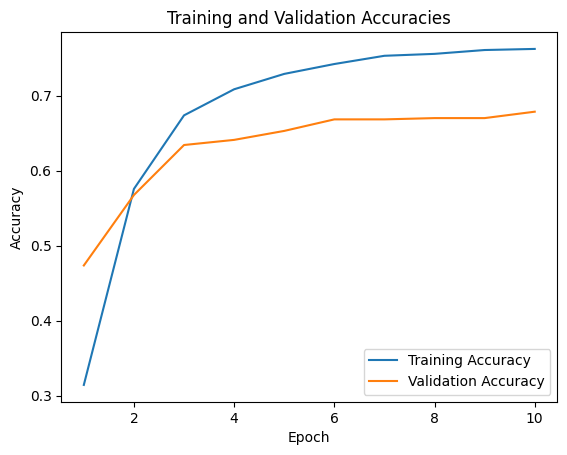

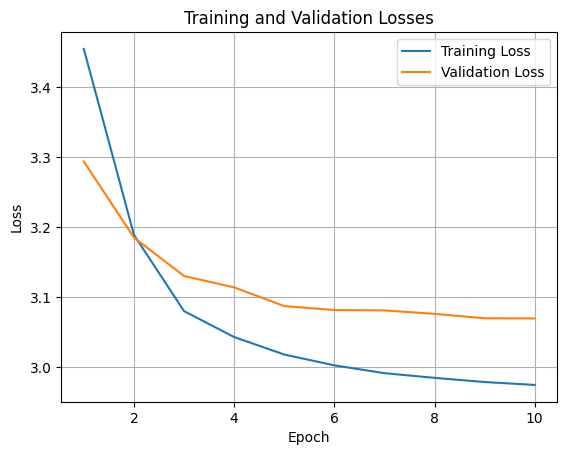

In [155]:
trainModel(tuned_squeezenet1_0_model, 10)

In [156]:
evalModel(tuned_squeezenet1_0_model, nn.CrossEntropyLoss())

Test Loss: 3.0515, Test Accuracy: 0.6945


#### squeezenet1_1

##### Load Model

In [157]:
default_weight_squeezenet1_1 = models.SqueezeNet1_1_Weights.DEFAULT
squeezenet1_1_model = models.squeezenet1_1(weights=default_weight_squeezenet1_1)

In [158]:
for param in squeezenet1_1_model.parameters():
    param.requires_grad = False

In [159]:



tuned_squeezenet1_1_model = squeezenet1_1_model

new_head = nn.Sequential(
    nn.Dropout(p=0.2),  # Dropout layer with 0.2 probability
    nn.Conv2d(512, 40, kernel_size=(1, 1), stride=(1, 1)),  # Convolutional layer with 40 filters
    nn.ReLU(inplace=True),  # ReLU activation
    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Adaptive average pooling layer
    nn.Flatten(),  # Flatten layers
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_squeezenet1_1_model.classifier = new_head


In [160]:
print(tuned_squeezenet1_1_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

##### Training

Epoch [1/10], Train Loss: 3.4600, Train Accuracy: 0.3072, Val Loss: 3.2457, Val Accuracy: 0.5368
Epoch [2/10], Train Loss: 3.1459, Train Accuracy: 0.6207, Val Loss: 3.1486, Val Accuracy: 0.6120
Epoch [3/10], Train Loss: 3.0617, Train Accuracy: 0.6953, Val Loss: 3.1025, Val Accuracy: 0.6513
Epoch [4/10], Train Loss: 3.0249, Train Accuracy: 0.7213, Val Loss: 3.0760, Val Accuracy: 0.6838
Epoch [5/10], Train Loss: 3.0047, Train Accuracy: 0.7404, Val Loss: 3.0641, Val Accuracy: 0.6872
Epoch [6/10], Train Loss: 2.9926, Train Accuracy: 0.7495, Val Loss: 3.0582, Val Accuracy: 0.6957
Epoch [7/10], Train Loss: 2.9854, Train Accuracy: 0.7558, Val Loss: 3.0668, Val Accuracy: 0.6855
Epoch [8/10], Train Loss: 2.9766, Train Accuracy: 0.7631, Val Loss: 3.0498, Val Accuracy: 0.7060
Epoch [9/10], Train Loss: 2.9734, Train Accuracy: 0.7624, Val Loss: 3.0495, Val Accuracy: 0.7026
Epoch [10/10], Train Loss: 2.9691, Train Accuracy: 0.7679, Val Loss: 3.0298, Val Accuracy: 0.7299


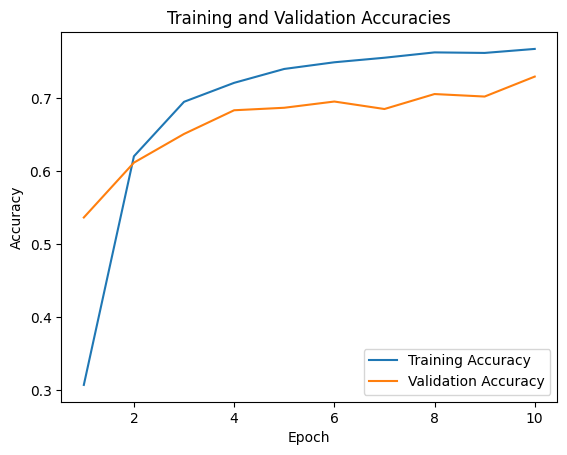

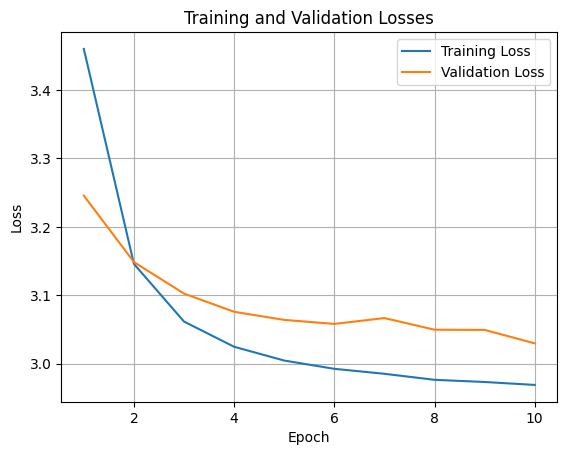

In [161]:
trainModel(tuned_squeezenet1_1_model, 10)

In [162]:
evalModel(tuned_squeezenet1_1_model, nn.CrossEntropyLoss())

Test Loss: 3.0282, Test Accuracy: 0.7253


## SwinTransformer

### Models

#### Swin_V2_t

##### Load Model

In [163]:
default_weight_swin_v2_t = models.Swin_V2_T_Weights.DEFAULT
swin_v2_t_model = models.swin_v2_t(weights=default_weight_swin_v2_t)

In [164]:
for param in swin_v2_t_model.parameters():
    param.requires_grad = False

In [165]:
num_features = swin_v2_t_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_swin_v2_t_model = swin_v2_t_model

tuned_swin_v2_t_model.head = new_head

In [166]:
print(tuned_swin_v2_t_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

##### Training

Epoch [1/10], Train Loss: 3.4064, Train Accuracy: 0.3662, Val Loss: 3.2010, Val Accuracy: 0.5368
Epoch [2/10], Train Loss: 3.1504, Train Accuracy: 0.5870, Val Loss: 3.1394, Val Accuracy: 0.5915
Epoch [3/10], Train Loss: 3.0853, Train Accuracy: 0.6518, Val Loss: 3.0835, Val Accuracy: 0.6496
Epoch [4/10], Train Loss: 3.0372, Train Accuracy: 0.6994, Val Loss: 3.0451, Val Accuracy: 0.6940
Epoch [5/10], Train Loss: 3.0276, Train Accuracy: 0.7071, Val Loss: 3.0361, Val Accuracy: 0.6974
Epoch [6/10], Train Loss: 3.0157, Train Accuracy: 0.7173, Val Loss: 3.0245, Val Accuracy: 0.7060
Epoch [7/10], Train Loss: 2.9898, Train Accuracy: 0.7448, Val Loss: 2.9957, Val Accuracy: 0.7385
Epoch [8/10], Train Loss: 2.9606, Train Accuracy: 0.7741, Val Loss: 3.0040, Val Accuracy: 0.7265
Epoch [9/10], Train Loss: 2.9473, Train Accuracy: 0.7880, Val Loss: 2.9605, Val Accuracy: 0.7761
Epoch [10/10], Train Loss: 2.9281, Train Accuracy: 0.8048, Val Loss: 2.9396, Val Accuracy: 0.7949


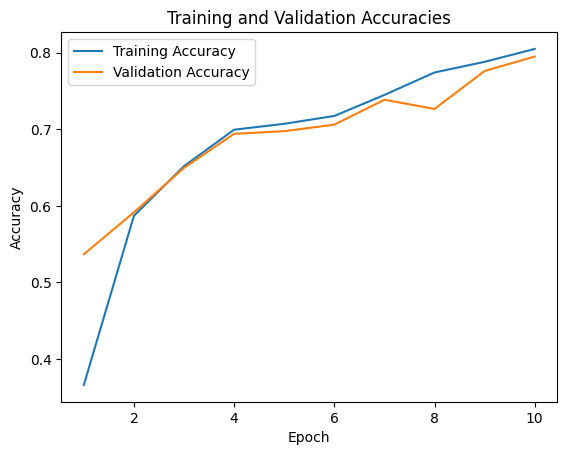

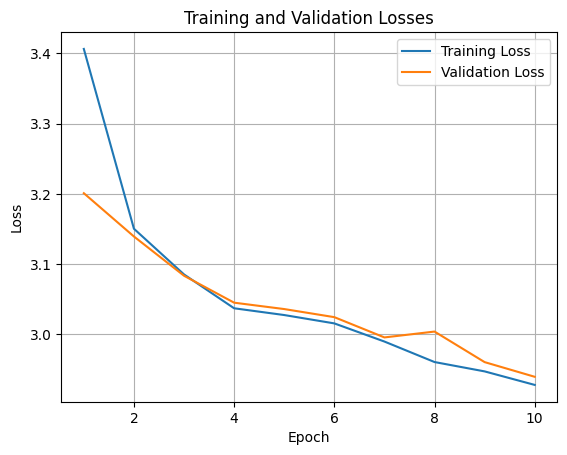

In [167]:
trainModel(tuned_swin_v2_t_model, 10)

In [168]:
evalModel(tuned_swin_v2_t_model, nn.CrossEntropyLoss())

Test Loss: 2.9326, Test Accuracy: 0.8038


#### Swin_V2_s

##### Load Model

In [169]:
default_weight_swin_v2_s = models.Swin_V2_S_Weights.DEFAULT
swin_v2_s_model = models.swin_v2_s(weights=default_weight_swin_v2_s)

In [170]:
for param in swin_v2_s_model.parameters():
    param.requires_grad = False

In [171]:
num_features = swin_v2_s_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_swin_v2_s_model = swin_v2_s_model

tuned_swin_v2_s_model.head = new_head

In [172]:
print(tuned_swin_v2_s_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=3, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='

##### Training

Epoch [1/10], Train Loss: 3.4042, Train Accuracy: 0.3790, Val Loss: 3.2024, Val Accuracy: 0.5453
Epoch [2/10], Train Loss: 3.1512, Train Accuracy: 0.5877, Val Loss: 3.1326, Val Accuracy: 0.6017
Epoch [3/10], Train Loss: 3.1107, Train Accuracy: 0.6254, Val Loss: 3.1216, Val Accuracy: 0.6103
Epoch [4/10], Train Loss: 3.0971, Train Accuracy: 0.6346, Val Loss: 3.1158, Val Accuracy: 0.6137
Epoch [5/10], Train Loss: 3.0937, Train Accuracy: 0.6382, Val Loss: 3.1140, Val Accuracy: 0.6171
Epoch [6/10], Train Loss: 3.0842, Train Accuracy: 0.6492, Val Loss: 3.1027, Val Accuracy: 0.6274
Epoch [7/10], Train Loss: 3.0793, Train Accuracy: 0.6521, Val Loss: 3.0864, Val Accuracy: 0.6462
Epoch [8/10], Train Loss: 3.0704, Train Accuracy: 0.6617, Val Loss: 3.0763, Val Accuracy: 0.6581
Epoch [9/10], Train Loss: 3.0527, Train Accuracy: 0.6807, Val Loss: 3.0781, Val Accuracy: 0.6564
Epoch [10/10], Train Loss: 3.0411, Train Accuracy: 0.6924, Val Loss: 3.0564, Val Accuracy: 0.6786


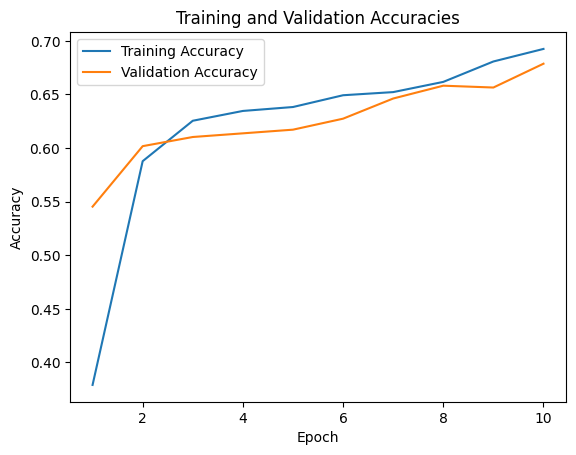

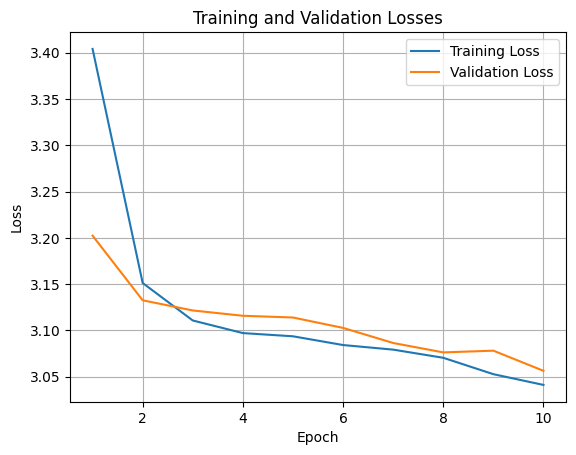

In [173]:
trainModel(tuned_swin_v2_s_model, 10)

In [174]:
evalModel(tuned_swin_v2_s_model, nn.CrossEntropyLoss())

Test Loss: 3.0779, Test Accuracy: 0.6536


#### Swin_V2_b

##### Load Model

In [175]:
default_weight_swin_v2_b = models.Swin_V2_B_Weights.DEFAULT
swin_v2_b_model = models.swin_v2_b(weights=default_weight_swin_v2_b)

In [176]:
for param in swin_v2_b_model.parameters():
    param.requires_grad = False

In [177]:
num_features = swin_v2_b_model.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_swin_v2_b_model = swin_v2_b_model

tuned_swin_v2_b_model.head = new_head

In [178]:
print(tuned_swin_v2_b_model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlockV2(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttentionV2(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
          (cpb_mlp): Sequential(
            (0): Linear(in_features=2, out_features=512, bias=True)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=512, out_features=4, bias=False)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(appro

##### Training

Epoch [1/10], Train Loss: 3.3985, Train Accuracy: 0.3911, Val Loss: 3.1952, Val Accuracy: 0.5470
Epoch [2/10], Train Loss: 3.1704, Train Accuracy: 0.5676, Val Loss: 3.1901, Val Accuracy: 0.5470
Epoch [3/10], Train Loss: 3.1300, Train Accuracy: 0.6060, Val Loss: 3.1431, Val Accuracy: 0.5897
Epoch [4/10], Train Loss: 3.0732, Train Accuracy: 0.6650, Val Loss: 3.0569, Val Accuracy: 0.6821
Epoch [5/10], Train Loss: 3.0146, Train Accuracy: 0.7213, Val Loss: 3.0404, Val Accuracy: 0.6923
Epoch [6/10], Train Loss: 2.9883, Train Accuracy: 0.7455, Val Loss: 3.0234, Val Accuracy: 0.7094
Epoch [7/10], Train Loss: 2.9690, Train Accuracy: 0.7649, Val Loss: 2.9934, Val Accuracy: 0.7419
Epoch [8/10], Train Loss: 2.9618, Train Accuracy: 0.7715, Val Loss: 2.9961, Val Accuracy: 0.7333
Epoch [9/10], Train Loss: 2.9592, Train Accuracy: 0.7737, Val Loss: 2.9864, Val Accuracy: 0.7487
Epoch [10/10], Train Loss: 2.9518, Train Accuracy: 0.7825, Val Loss: 2.9707, Val Accuracy: 0.7624


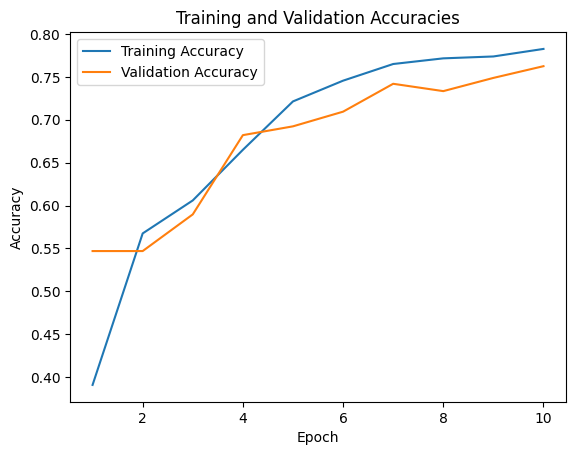

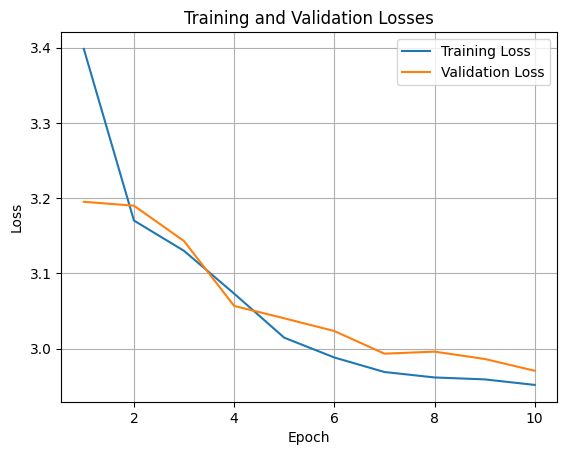

In [179]:
trainModel(tuned_swin_v2_b_model, 10)

In [180]:
evalModel(tuned_swin_v2_b_model, nn.CrossEntropyLoss())

Test Loss: 2.9633, Test Accuracy: 0.7679


## VGG

### Models

#### VGG11

##### Load Model

In [10]:
default_weight_vgg11 = models.VGG11_Weights.DEFAULT
vgg11_model = models.vgg11(weights=default_weight_vgg11)

In [11]:
for param in vgg11_model.parameters():
    param.requires_grad = False

In [12]:
num_features = vgg11_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg11_model = vgg11_model

tuned_vgg11_model.classifier = new_head

In [13]:
print(tuned_vgg11_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Train Loss: 3.4784, Train Accuracy: 0.2563, Val Loss: 3.3717, Val Accuracy: 0.3590
Epoch [2/10], Train Loss: 3.3366, Train Accuracy: 0.3944, Val Loss: 3.3468, Val Accuracy: 0.3863
Epoch [3/10], Train Loss: 3.2647, Train Accuracy: 0.4636, Val Loss: 3.3025, Val Accuracy: 0.4274
Epoch [4/10], Train Loss: 3.2400, Train Accuracy: 0.4914, Val Loss: 3.3070, Val Accuracy: 0.4205
Epoch [5/10], Train Loss: 3.2184, Train Accuracy: 0.5134, Val Loss: 3.2597, Val Accuracy: 0.4735
Epoch [6/10], Train Loss: 3.1982, Train Accuracy: 0.5328, Val Loss: 3.2608, Val Accuracy: 0.4718
Epoch [7/10], Train Loss: 3.1812, Train Accuracy: 0.5492, Val Loss: 3.2423, Val Accuracy: 0.4872
Epoch [8/10], Train Loss: 3.1700, Train Accuracy: 0.5599, Val Loss: 3.2423, Val Accuracy: 0.4872
Epoch [9/10], Train Loss: 3.1659, Train Accuracy: 0.5646, Val Loss: 3.2135, Val Accuracy: 0.5197
Epoch [10/10], Train Loss: 3.1600, Train Accuracy: 0.5701, Val Loss: 3.2319, Val Accuracy: 0.4974


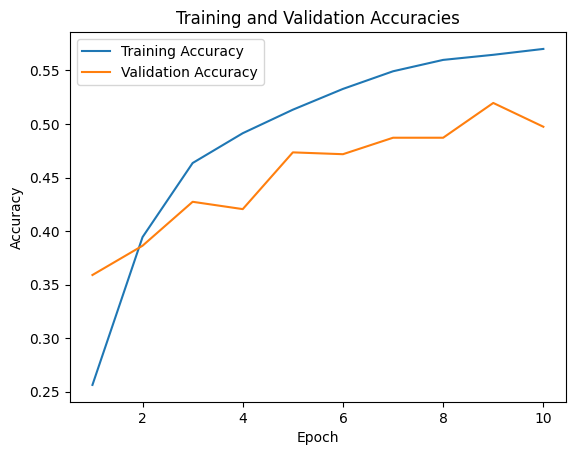

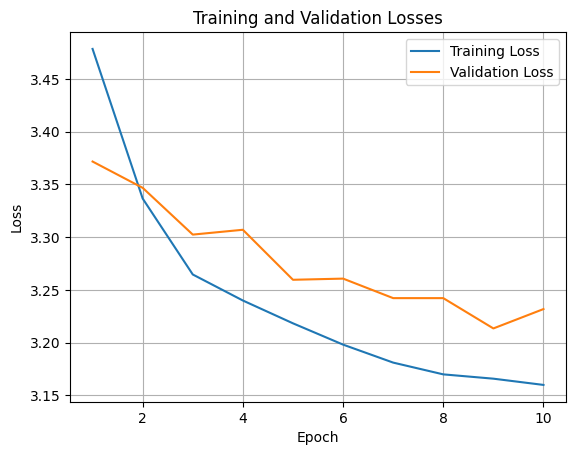

In [14]:
trainModel(tuned_vgg11_model, 10)

In [15]:
evalModel(tuned_vgg11_model, nn.CrossEntropyLoss())

Test Loss: 3.2092, Test Accuracy: 0.5188


#### VGG11_bn

##### Load Model

In [16]:
default_weight_vgg11_bn = models.VGG11_BN_Weights.DEFAULT
vgg11_bn_model = models.vgg11_bn(weights=default_weight_vgg11_bn)

In [17]:
for param in vgg11_bn_model.parameters():
    param.requires_grad = False

In [18]:
num_features = vgg11_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg11_bn_model = vgg11_bn_model

tuned_vgg11_bn_model.classifier = new_head

In [19]:
print(tuned_vgg11_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

##### Training

Epoch [1/10], Train Loss: 3.5094, Train Accuracy: 0.2263, Val Loss: 3.3863, Val Accuracy: 0.3470
Epoch [2/10], Train Loss: 3.3313, Train Accuracy: 0.3995, Val Loss: 3.3281, Val Accuracy: 0.4051
Epoch [3/10], Train Loss: 3.2745, Train Accuracy: 0.4566, Val Loss: 3.3116, Val Accuracy: 0.4239
Epoch [4/10], Train Loss: 3.2082, Train Accuracy: 0.5233, Val Loss: 3.2648, Val Accuracy: 0.4632
Epoch [5/10], Train Loss: 3.1681, Train Accuracy: 0.5628, Val Loss: 3.2373, Val Accuracy: 0.4974
Epoch [6/10], Train Loss: 3.1197, Train Accuracy: 0.6119, Val Loss: 3.1877, Val Accuracy: 0.5470
Epoch [7/10], Train Loss: 3.0919, Train Accuracy: 0.6408, Val Loss: 3.1659, Val Accuracy: 0.5726
Epoch [8/10], Train Loss: 3.0758, Train Accuracy: 0.6547, Val Loss: 3.1867, Val Accuracy: 0.5521
Epoch [9/10], Train Loss: 3.0672, Train Accuracy: 0.6639, Val Loss: 3.1643, Val Accuracy: 0.5692
Epoch [10/10], Train Loss: 3.0582, Train Accuracy: 0.6723, Val Loss: 3.1514, Val Accuracy: 0.5795


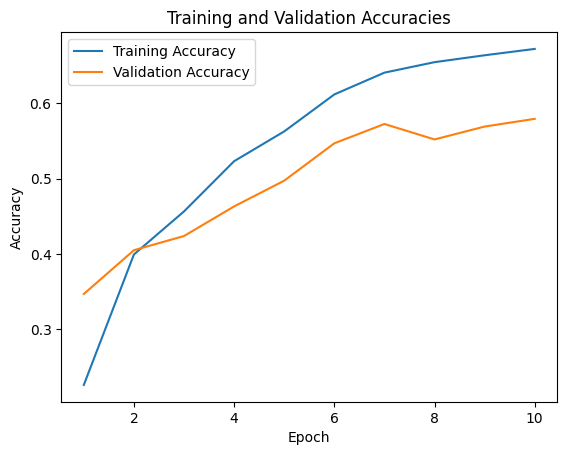

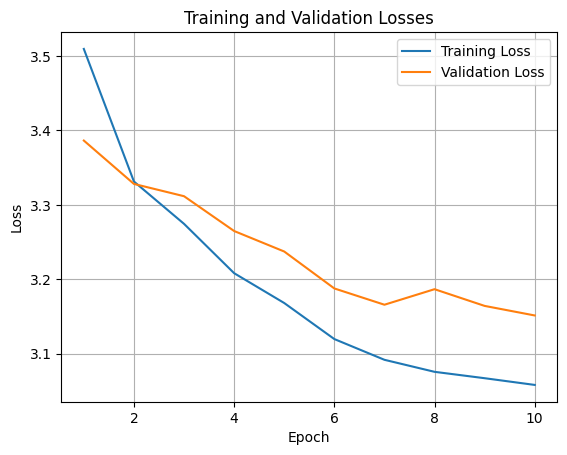

In [20]:
trainModel(tuned_vgg11_bn_model, 10)

In [21]:
evalModel(tuned_vgg11_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.1432, Test Accuracy: 0.5904


#### VGG13

##### Load Model

In [22]:
default_weight_vgg13 = models.VGG13_Weights.DEFAULT
vgg13_model = models.vgg13(weights=default_weight_vgg13)

In [23]:
for param in vgg13_model.parameters():
    param.requires_grad = False

In [24]:
num_features = vgg13_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg13_model = vgg13_model

tuned_vgg13_model.classifier = new_head

In [25]:
print(tuned_vgg13_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

##### Training

Epoch [1/10], Train Loss: 3.4340, Train Accuracy: 0.2981, Val Loss: 3.4094, Val Accuracy: 0.3231
Epoch [2/10], Train Loss: 3.2997, Train Accuracy: 0.4328, Val Loss: 3.3235, Val Accuracy: 0.4085
Epoch [3/10], Train Loss: 3.2469, Train Accuracy: 0.4833, Val Loss: 3.2920, Val Accuracy: 0.4427
Epoch [4/10], Train Loss: 3.2282, Train Accuracy: 0.5027, Val Loss: 3.2805, Val Accuracy: 0.4496
Epoch [5/10], Train Loss: 3.2105, Train Accuracy: 0.5200, Val Loss: 3.2697, Val Accuracy: 0.4632
Epoch [6/10], Train Loss: 3.2061, Train Accuracy: 0.5251, Val Loss: 3.2433, Val Accuracy: 0.4872
Epoch [7/10], Train Loss: 3.1746, Train Accuracy: 0.5547, Val Loss: 3.2201, Val Accuracy: 0.5128
Epoch [8/10], Train Loss: 3.1622, Train Accuracy: 0.5683, Val Loss: 3.2629, Val Accuracy: 0.4701
Epoch [9/10], Train Loss: 3.1530, Train Accuracy: 0.5774, Val Loss: 3.2108, Val Accuracy: 0.5162
Epoch [10/10], Train Loss: 3.1587, Train Accuracy: 0.5716, Val Loss: 3.2520, Val Accuracy: 0.4786


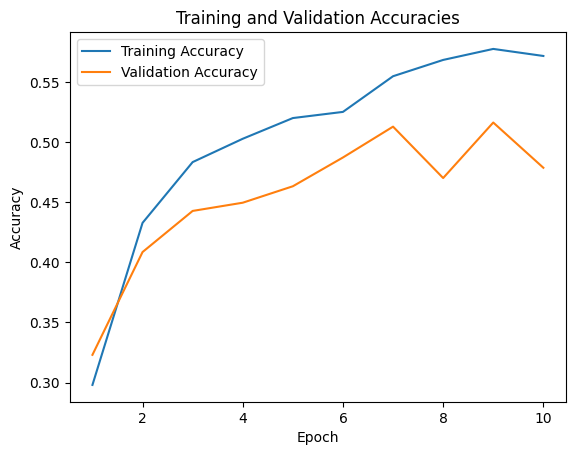

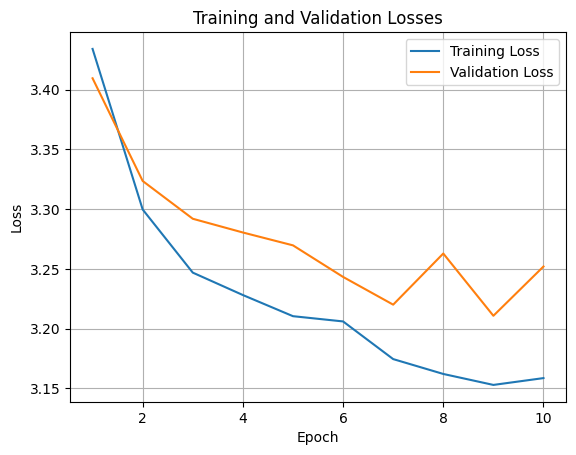

In [26]:
trainModel(tuned_vgg13_model, 10)

In [27]:
evalModel(tuned_vgg13_model, nn.CrossEntropyLoss())

Test Loss: 3.2251, Test Accuracy: 0.5034


#### VGG13_bn

##### Load Model

In [28]:
default_weight_vgg13_bn = models.VGG13_BN_Weights.DEFAULT
vgg13_bn_model = models.vgg13_bn(weights=default_weight_vgg13_bn)

In [29]:
for param in vgg13_bn_model.parameters():
    param.requires_grad = False

In [30]:
num_features = vgg13_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg13_bn_model = vgg13_bn_model

tuned_vgg13_bn_model.classifier = new_head

In [31]:
print(tuned_vgg13_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Training

Epoch [1/10], Train Loss: 3.5947, Train Accuracy: 0.1351, Val Loss: 3.4613, Val Accuracy: 0.2769
Epoch [2/10], Train Loss: 3.4115, Train Accuracy: 0.3219, Val Loss: 3.3755, Val Accuracy: 0.3573
Epoch [3/10], Train Loss: 3.3478, Train Accuracy: 0.3834, Val Loss: 3.3498, Val Accuracy: 0.3829
Epoch [4/10], Train Loss: 3.2684, Train Accuracy: 0.4632, Val Loss: 3.2516, Val Accuracy: 0.4786
Epoch [5/10], Train Loss: 3.1964, Train Accuracy: 0.5353, Val Loss: 3.2122, Val Accuracy: 0.5265
Epoch [6/10], Train Loss: 3.1727, Train Accuracy: 0.5584, Val Loss: 3.2170, Val Accuracy: 0.5162
Epoch [7/10], Train Loss: 3.1463, Train Accuracy: 0.5833, Val Loss: 3.2042, Val Accuracy: 0.5282
Epoch [8/10], Train Loss: 3.1229, Train Accuracy: 0.6075, Val Loss: 3.1966, Val Accuracy: 0.5333
Epoch [9/10], Train Loss: 3.1130, Train Accuracy: 0.6185, Val Loss: 3.1723, Val Accuracy: 0.5590
Epoch [10/10], Train Loss: 3.1127, Train Accuracy: 0.6170, Val Loss: 3.2010, Val Accuracy: 0.5282


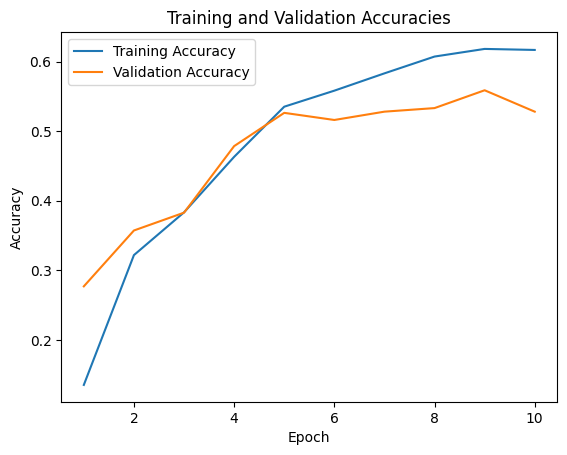

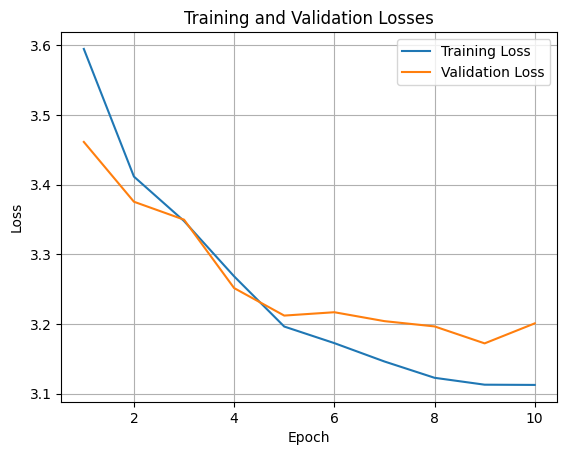

In [32]:
trainModel(tuned_vgg13_bn_model, 10)

In [33]:
evalModel(tuned_vgg13_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.1909, Test Accuracy: 0.5410


#### VGG16

##### Load Model

In [34]:
default_weight_vgg16 = models.VGG16_Weights.DEFAULT
vgg16_model = models.vgg16(weights=default_weight_vgg16)

In [35]:
for param in vgg16_model.parameters():
    param.requires_grad = False

In [36]:
num_features = vgg16_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg16_model = vgg16_model

tuned_vgg16_model.classifier = new_head

In [37]:
print(tuned_vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

##### Training

Epoch [1/10], Train Loss: 3.5308, Train Accuracy: 0.1981, Val Loss: 3.4753, Val Accuracy: 0.2564
Epoch [2/10], Train Loss: 3.4124, Train Accuracy: 0.3175, Val Loss: 3.4164, Val Accuracy: 0.3179
Epoch [3/10], Train Loss: 3.3535, Train Accuracy: 0.3764, Val Loss: 3.4271, Val Accuracy: 0.2991
Epoch [4/10], Train Loss: 3.3240, Train Accuracy: 0.4064, Val Loss: 3.3783, Val Accuracy: 0.3470
Epoch [5/10], Train Loss: 3.2796, Train Accuracy: 0.4500, Val Loss: 3.3106, Val Accuracy: 0.4222
Epoch [6/10], Train Loss: 3.2594, Train Accuracy: 0.4716, Val Loss: 3.3083, Val Accuracy: 0.4222
Epoch [7/10], Train Loss: 3.2494, Train Accuracy: 0.4800, Val Loss: 3.3042, Val Accuracy: 0.4239
Epoch [8/10], Train Loss: 3.2295, Train Accuracy: 0.5005, Val Loss: 3.3317, Val Accuracy: 0.3983
Epoch [9/10], Train Loss: 3.2298, Train Accuracy: 0.5005, Val Loss: 3.2892, Val Accuracy: 0.4359
Epoch [10/10], Train Loss: 3.2109, Train Accuracy: 0.5192, Val Loss: 3.2728, Val Accuracy: 0.4598


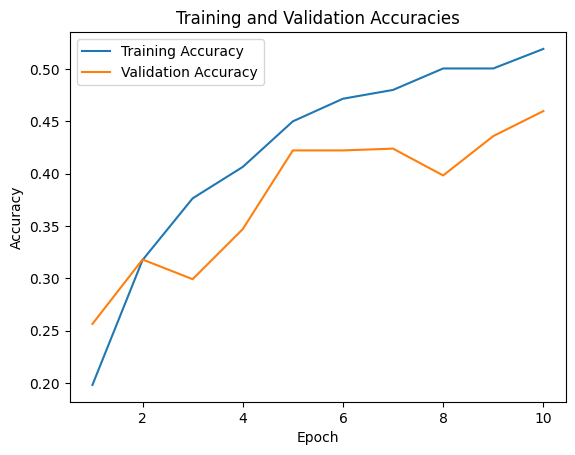

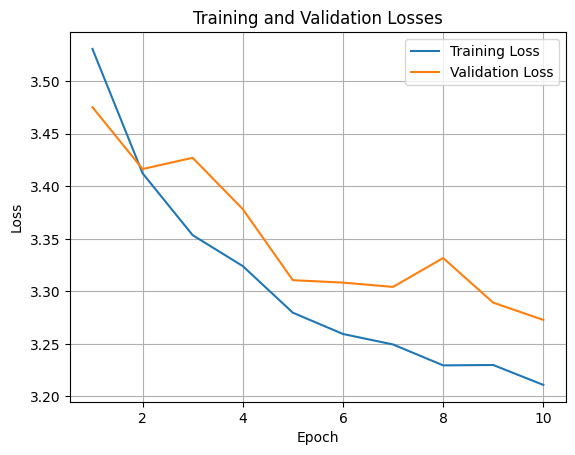

In [38]:
trainModel(tuned_vgg16_model, 10)

In [39]:
evalModel(tuned_vgg16_model, nn.CrossEntropyLoss())

Test Loss: 3.2677, Test Accuracy: 0.4625


#### VGG16_bn

##### Load Model

In [40]:
default_weight_vgg16_bn = models.VGG16_BN_Weights.DEFAULT
vgg16_bn_model = models.vgg16_bn(weights=default_weight_vgg16_bn)

In [41]:
for param in vgg16_bn_model.parameters():
    param.requires_grad = False

In [42]:
num_features = vgg16_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg16_bn_model = vgg16_bn_model

tuned_vgg16_bn_model.classifier = new_head

In [43]:
print(tuned_vgg16_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Training

Epoch [1/10], Train Loss: 3.4571, Train Accuracy: 0.2819, Val Loss: 3.3635, Val Accuracy: 0.3744
Epoch [2/10], Train Loss: 3.3072, Train Accuracy: 0.4269, Val Loss: 3.3479, Val Accuracy: 0.3897
Epoch [3/10], Train Loss: 3.2368, Train Accuracy: 0.4954, Val Loss: 3.2231, Val Accuracy: 0.5145
Epoch [4/10], Train Loss: 3.1730, Train Accuracy: 0.5584, Val Loss: 3.2555, Val Accuracy: 0.4838
Epoch [5/10], Train Loss: 3.1365, Train Accuracy: 0.5954, Val Loss: 3.2031, Val Accuracy: 0.5299
Epoch [6/10], Train Loss: 3.1247, Train Accuracy: 0.6056, Val Loss: 3.1903, Val Accuracy: 0.5419
Epoch [7/10], Train Loss: 3.1086, Train Accuracy: 0.6214, Val Loss: 3.2079, Val Accuracy: 0.5248
Epoch [8/10], Train Loss: 3.1100, Train Accuracy: 0.6210, Val Loss: 3.1475, Val Accuracy: 0.5880
Epoch [9/10], Train Loss: 3.0812, Train Accuracy: 0.6496, Val Loss: 3.1445, Val Accuracy: 0.5829
Epoch [10/10], Train Loss: 3.0642, Train Accuracy: 0.6668, Val Loss: 3.1399, Val Accuracy: 0.5949


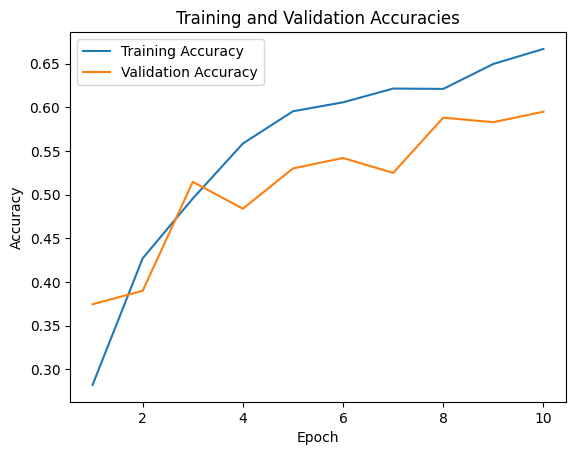

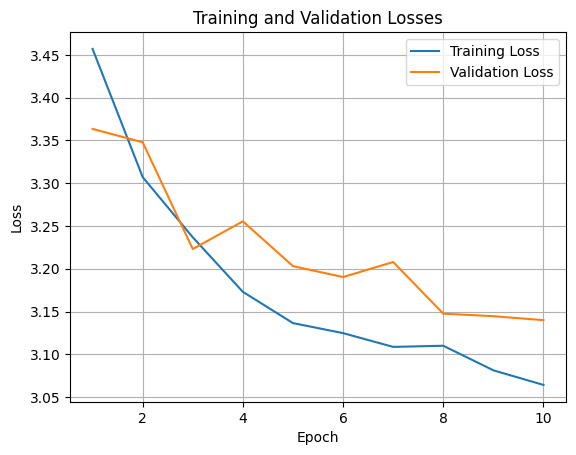

In [44]:
trainModel(tuned_vgg16_bn_model, 10)

In [45]:
evalModel(tuned_vgg16_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.1473, Test Accuracy: 0.5819


#### VGG19

##### Load Model

In [46]:
default_weight_vgg19 = models.VGG19_Weights.DEFAULT
vgg19_model = models.vgg19(weights=default_weight_vgg19)

In [47]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [48]:
num_features = vgg19_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg19_model = vgg19_model

tuned_vgg19_model.classifier = new_head

In [49]:
print(tuned_vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##### Training

Epoch [1/10], Train Loss: 3.4631, Train Accuracy: 0.2706, Val Loss: 3.3644, Val Accuracy: 0.3675
Epoch [2/10], Train Loss: 3.3515, Train Accuracy: 0.3797, Val Loss: 3.3985, Val Accuracy: 0.3316
Epoch [3/10], Train Loss: 3.3531, Train Accuracy: 0.3775, Val Loss: 3.3457, Val Accuracy: 0.3829
Epoch [4/10], Train Loss: 3.3073, Train Accuracy: 0.4240, Val Loss: 3.3769, Val Accuracy: 0.3521
Epoch [5/10], Train Loss: 3.2913, Train Accuracy: 0.4394, Val Loss: 3.3386, Val Accuracy: 0.3915
Epoch [6/10], Train Loss: 3.3005, Train Accuracy: 0.4295, Val Loss: 3.3452, Val Accuracy: 0.3880
Epoch [7/10], Train Loss: 3.2824, Train Accuracy: 0.4482, Val Loss: 3.3356, Val Accuracy: 0.3949
Epoch [8/10], Train Loss: 3.2808, Train Accuracy: 0.4500, Val Loss: 3.3255, Val Accuracy: 0.4068
Epoch [9/10], Train Loss: 3.2750, Train Accuracy: 0.4551, Val Loss: 3.3619, Val Accuracy: 0.3675
Epoch [10/10], Train Loss: 3.2613, Train Accuracy: 0.4687, Val Loss: 3.3306, Val Accuracy: 0.4017


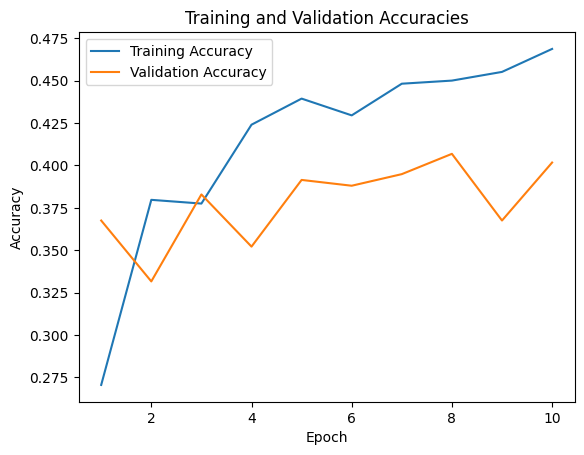

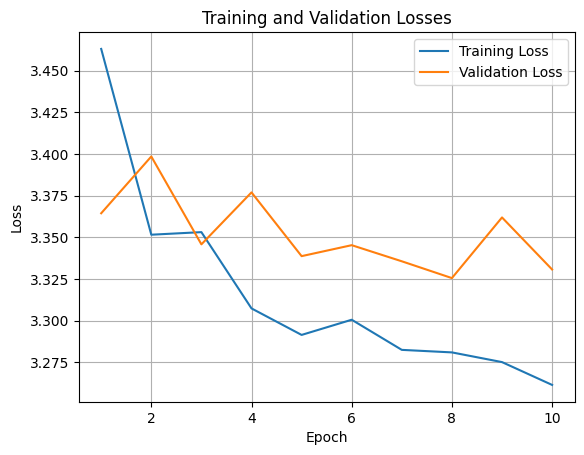

In [50]:
trainModel(tuned_vgg19_model, 10)

In [51]:
evalModel(tuned_vgg19_model, nn.CrossEntropyLoss())

Test Loss: 3.3373, Test Accuracy: 0.3925


#### VGG19_bn

##### Load Model

In [52]:
default_weight_vgg19_bn = models.VGG19_BN_Weights.DEFAULT
vgg19_bn_model = models.vgg19_bn(weights=default_weight_vgg19_bn)

In [53]:
for param in vgg19_bn_model.parameters():
    param.requires_grad = False

In [54]:
num_features = vgg19_bn_model.classifier[0].in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vgg19_bn_model = vgg19_bn_model

tuned_vgg19_bn_model.classifier = new_head

In [55]:
print(tuned_vgg19_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##### Training

Epoch [1/10], Train Loss: 3.4588, Train Accuracy: 0.2819, Val Loss: 3.3291, Val Accuracy: 0.4034
Epoch [2/10], Train Loss: 3.2592, Train Accuracy: 0.4775, Val Loss: 3.2583, Val Accuracy: 0.4735
Epoch [3/10], Train Loss: 3.1961, Train Accuracy: 0.5368, Val Loss: 3.2443, Val Accuracy: 0.4940
Epoch [4/10], Train Loss: 3.1721, Train Accuracy: 0.5584, Val Loss: 3.2098, Val Accuracy: 0.5231
Epoch [5/10], Train Loss: 3.1279, Train Accuracy: 0.6049, Val Loss: 3.1603, Val Accuracy: 0.5744
Epoch [6/10], Train Loss: 3.0802, Train Accuracy: 0.6510, Val Loss: 3.1723, Val Accuracy: 0.5607
Epoch [7/10], Train Loss: 3.0611, Train Accuracy: 0.6701, Val Loss: 3.1350, Val Accuracy: 0.5983
Epoch [8/10], Train Loss: 3.0499, Train Accuracy: 0.6807, Val Loss: 3.1036, Val Accuracy: 0.6256
Epoch [9/10], Train Loss: 3.0459, Train Accuracy: 0.6855, Val Loss: 3.1157, Val Accuracy: 0.6205
Epoch [10/10], Train Loss: 3.0482, Train Accuracy: 0.6822, Val Loss: 3.1400, Val Accuracy: 0.6000


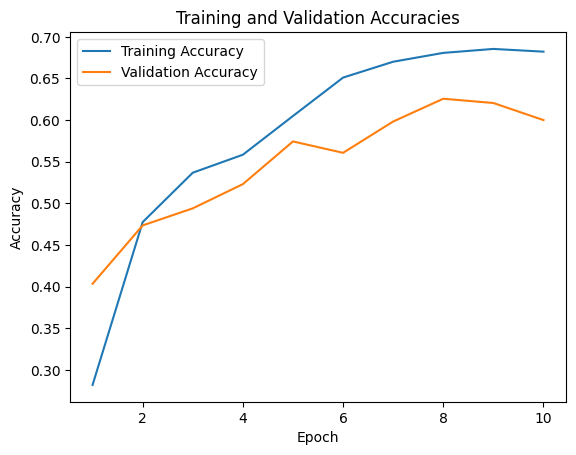

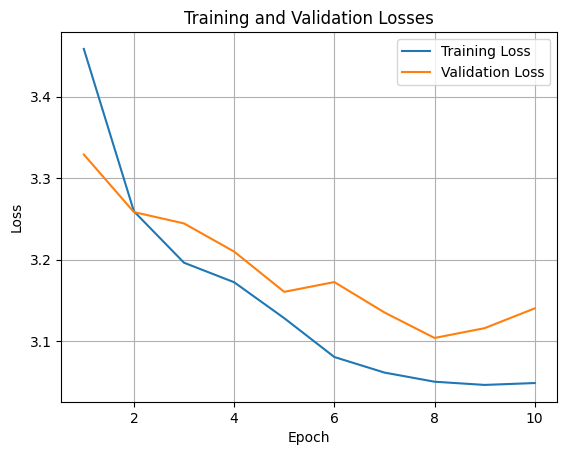

In [56]:
trainModel(tuned_vgg19_bn_model, 10)

In [57]:
evalModel(tuned_vgg19_bn_model, nn.CrossEntropyLoss())

Test Loss: 3.1708, Test Accuracy: 0.5614


## VisionTransformer

### Models

#### Vit_b_16

##### Load Model

In [58]:
default_weight_vit_b_16 = models.ViT_B_16_Weights.DEFAULT
vit_b_16_model = models.vit_b_16(weights=default_weight_vit_b_16)

In [59]:
for param in vit_b_16_model.parameters():
    param.requires_grad = False

In [60]:
num_features = vit_b_16_model.heads.head.in_features

new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)
tuned_vit_b_16_model = vit_b_16_model

tuned_vit_b_16_model.heads = new_head

In [61]:
print(tuned_vit_b_16_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##### Training

c:\Users\patri\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/10], Train Loss: 3.3658, Train Accuracy: 0.4280, Val Loss: 3.1988, Val Accuracy: 0.5436
Epoch [2/10], Train Loss: 3.1204, Train Accuracy: 0.6166, Val Loss: 3.1159, Val Accuracy: 0.6222
Epoch [3/10], Train Loss: 3.0412, Train Accuracy: 0.6939, Val Loss: 3.0589, Val Accuracy: 0.6752
Epoch [4/10], Train Loss: 2.9980, Train Accuracy: 0.7353, Val Loss: 3.0403, Val Accuracy: 0.7009
Epoch [5/10], Train Loss: 2.9570, Train Accuracy: 0.7770, Val Loss: 2.9960, Val Accuracy: 0.7402
Epoch [6/10], Train Loss: 2.9324, Train Accuracy: 0.8015, Val Loss: 2.9989, Val Accuracy: 0.7368
Epoch [7/10], Train Loss: 2.9355, Train Accuracy: 0.7957, Val Loss: 2.9943, Val Accuracy: 0.7402
Epoch [8/10], Train Loss: 2.9164, Train Accuracy: 0.8147, Val Loss: 2.9792, Val Accuracy: 0.7556
Epoch [9/10], Train Loss: 2.9131, Train Accuracy: 0.8169, Val Loss: 2.9794, Val Accuracy: 0.7556
Epoch [10/10], Train Loss: 2.9027, Train Accuracy: 0.8279, Val Loss: 2.9779, Val Accuracy: 0.7556


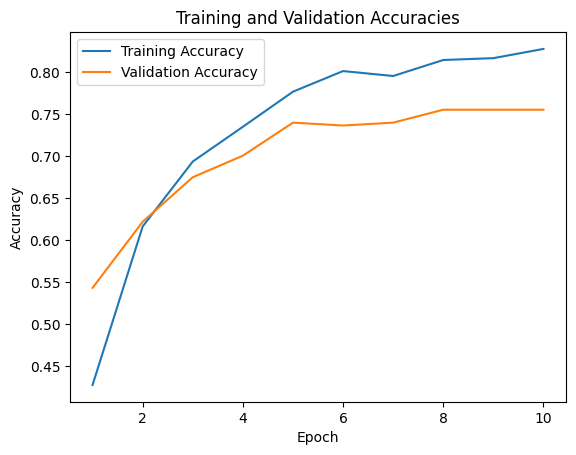

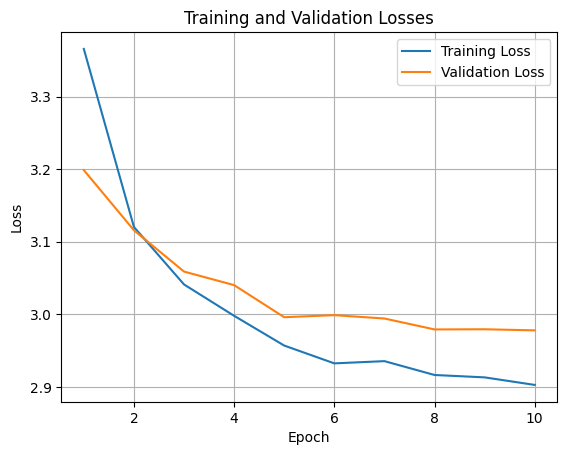

In [62]:
trainModel(tuned_vit_b_16_model, 10)

In [63]:
evalModel(tuned_vit_b_16_model, nn.CrossEntropyLoss())

Test Loss: 2.9630, Test Accuracy: 0.7747


#### Vit_b_32

##### Load Model

In [64]:
default_weight_vit_b_32 = models.ViT_B_32_Weights.DEFAULT
vit_b_32_model = models.vit_b_32(weights=default_weight_vit_b_32)

In [65]:
for param in vit_b_32_model.parameters():
    param.requires_grad = False

In [66]:
num_features = vit_b_32_model.heads.head.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_vit_b_32_model = vit_b_32_model

tuned_vit_b_32_model.heads = new_head

In [67]:
print(tuned_vit_b_32_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

##### Training

Epoch [1/10], Train Loss: 3.4128, Train Accuracy: 0.3662, Val Loss: 3.2563, Val Accuracy: 0.4838
Epoch [2/10], Train Loss: 3.1356, Train Accuracy: 0.6064, Val Loss: 3.1202, Val Accuracy: 0.6222
Epoch [3/10], Train Loss: 3.0529, Train Accuracy: 0.6844, Val Loss: 3.0797, Val Accuracy: 0.6530
Epoch [4/10], Train Loss: 3.0061, Train Accuracy: 0.7272, Val Loss: 3.0713, Val Accuracy: 0.6650
Epoch [5/10], Train Loss: 2.9677, Train Accuracy: 0.7657, Val Loss: 3.0110, Val Accuracy: 0.7282
Epoch [6/10], Train Loss: 2.9302, Train Accuracy: 0.8037, Val Loss: 3.0228, Val Accuracy: 0.7094
Epoch [7/10], Train Loss: 2.9150, Train Accuracy: 0.8198, Val Loss: 3.0042, Val Accuracy: 0.7282
Epoch [8/10], Train Loss: 2.9054, Train Accuracy: 0.8272, Val Loss: 2.9916, Val Accuracy: 0.7470
Epoch [9/10], Train Loss: 2.8905, Train Accuracy: 0.8418, Val Loss: 2.9772, Val Accuracy: 0.7556
Epoch [10/10], Train Loss: 2.8831, Train Accuracy: 0.8491, Val Loss: 2.9799, Val Accuracy: 0.7538


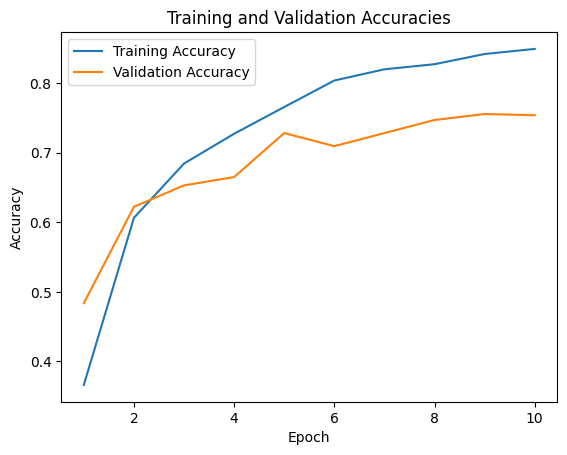

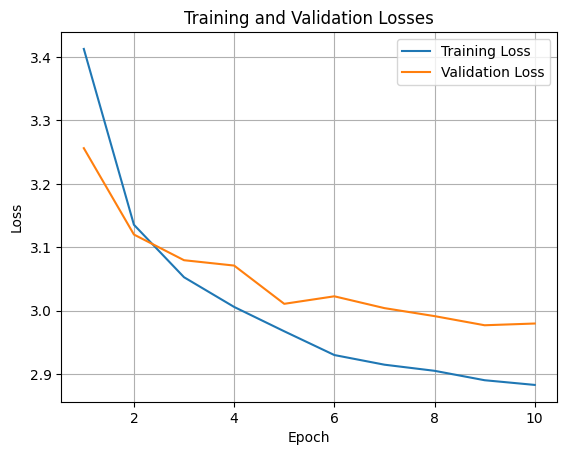

In [68]:
trainModel(tuned_vit_b_32_model, 10)

In [69]:
evalModel(tuned_vit_b_32_model, nn.CrossEntropyLoss())

Test Loss: 2.9586, Test Accuracy: 0.7765


## Wide ResNet

### Models

#### WideResNet50_2

##### Load Model

In [70]:
default_weight_wide_resnet50_2 = models.Wide_ResNet50_2_Weights.DEFAULT
wide_resnet50_2_model = models.wide_resnet50_2(weights=default_weight_wide_resnet50_2)

In [71]:
for param in wide_resnet50_2_model.parameters():
    param.requires_grad = False

In [72]:
num_features = wide_resnet50_2_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_wide_resnet50_2_model = wide_resnet50_2_model

tuned_wide_resnet50_2_model.fc = new_head

In [73]:
print(tuned_wide_resnet50_2_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

##### Training

Epoch [1/10], Train Loss: 3.5149, Train Accuracy: 0.2409, Val Loss: 3.3279, Val Accuracy: 0.4342
Epoch [2/10], Train Loss: 3.2153, Train Accuracy: 0.5328, Val Loss: 3.1852, Val Accuracy: 0.5521
Epoch [3/10], Train Loss: 3.1497, Train Accuracy: 0.5851, Val Loss: 3.1693, Val Accuracy: 0.5692
Epoch [4/10], Train Loss: 3.1145, Train Accuracy: 0.6207, Val Loss: 3.1350, Val Accuracy: 0.6103
Epoch [5/10], Train Loss: 3.0824, Train Accuracy: 0.6521, Val Loss: 3.1266, Val Accuracy: 0.6034
Epoch [6/10], Train Loss: 3.0636, Train Accuracy: 0.6719, Val Loss: 3.1026, Val Accuracy: 0.6291
Epoch [7/10], Train Loss: 3.0435, Train Accuracy: 0.6906, Val Loss: 3.0662, Val Accuracy: 0.6718
Epoch [8/10], Train Loss: 3.0091, Train Accuracy: 0.7243, Val Loss: 3.0745, Val Accuracy: 0.6581
Epoch [9/10], Train Loss: 2.9989, Train Accuracy: 0.7327, Val Loss: 3.0441, Val Accuracy: 0.6940
Epoch [10/10], Train Loss: 2.9799, Train Accuracy: 0.7528, Val Loss: 3.0402, Val Accuracy: 0.6923


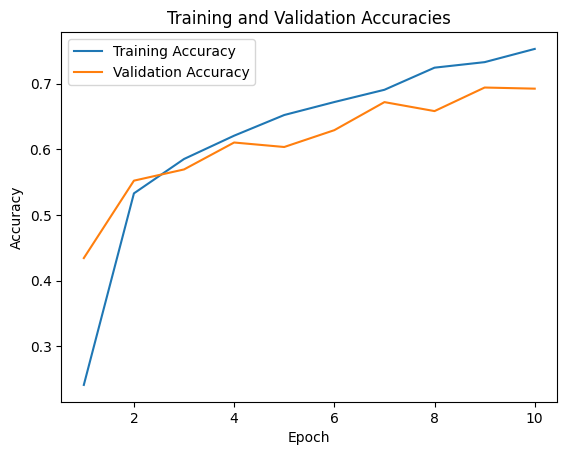

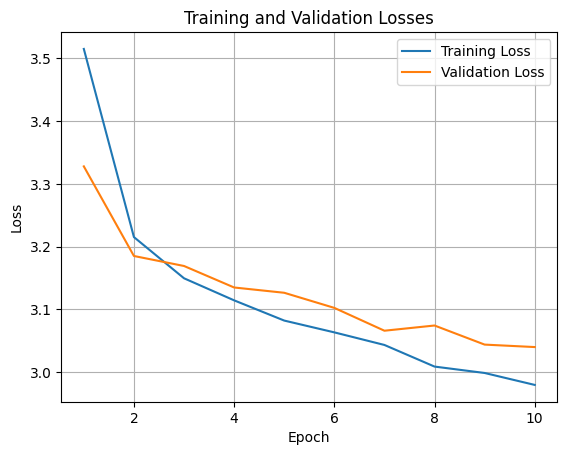

In [74]:
trainModel(tuned_wide_resnet50_2_model, 10)

In [75]:
evalModel(tuned_wide_resnet50_2_model, nn.CrossEntropyLoss())

Test Loss: 3.0096, Test Accuracy: 0.7338


#### WideResNet101_2

##### Load Model

In [76]:
default_weight_wide_resnet101_2 = models.Wide_ResNet101_2_Weights.DEFAULT
wide_resnet101_2_model = models.wide_resnet101_2(weights=default_weight_wide_resnet101_2)

In [77]:
for param in wide_resnet101_2_model.parameters():
    param.requires_grad = False

In [78]:
num_features = wide_resnet101_2_model.fc.in_features
new_head = nn.Sequential(
    nn.Linear(num_features, 512),  # Fully connected layer with 512 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(512, 256),  # Fully connected layer with 256 units
    nn.ReLU(inplace=True),  # ReLU activation
    nn.Linear(256, 40),  # Output layer with 40 units for 40 classes
    nn.Softmax(dim=1)  # Softmax activation for classification
)

tuned_wide_resnet101_2_model = wide_resnet101_2_model

tuned_wide_resnet101_2_model.fc = new_head

In [79]:
print(tuned_wide_resnet101_2_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

##### Training

Epoch [1/10], Train Loss: 3.4837, Train Accuracy: 0.2812, Val Loss: 3.2660, Val Accuracy: 0.4821
Epoch [2/10], Train Loss: 3.2395, Train Accuracy: 0.5002, Val Loss: 3.2317, Val Accuracy: 0.5145
Epoch [3/10], Train Loss: 3.1910, Train Accuracy: 0.5438, Val Loss: 3.1980, Val Accuracy: 0.5368
Epoch [4/10], Train Loss: 3.1597, Train Accuracy: 0.5723, Val Loss: 3.1613, Val Accuracy: 0.5778
Epoch [5/10], Train Loss: 3.1028, Train Accuracy: 0.6357, Val Loss: 3.1098, Val Accuracy: 0.6256
Epoch [6/10], Train Loss: 3.0796, Train Accuracy: 0.6551, Val Loss: 3.1022, Val Accuracy: 0.6393
Epoch [7/10], Train Loss: 3.0376, Train Accuracy: 0.6990, Val Loss: 3.0906, Val Accuracy: 0.6462
Epoch [8/10], Train Loss: 3.0223, Train Accuracy: 0.7085, Val Loss: 3.0596, Val Accuracy: 0.6752
Epoch [9/10], Train Loss: 2.9992, Train Accuracy: 0.7338, Val Loss: 3.0699, Val Accuracy: 0.6701
Epoch [10/10], Train Loss: 3.0035, Train Accuracy: 0.7301, Val Loss: 3.0592, Val Accuracy: 0.6803


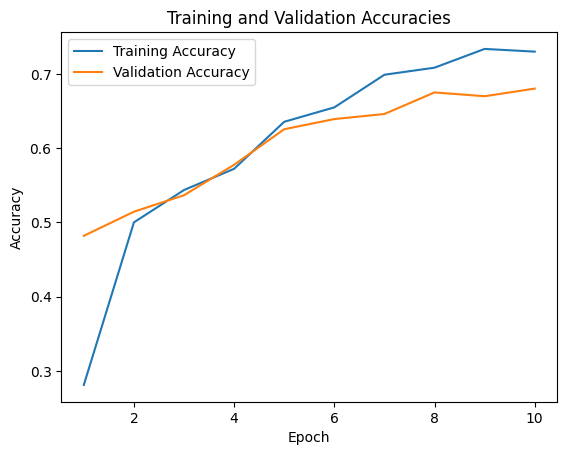

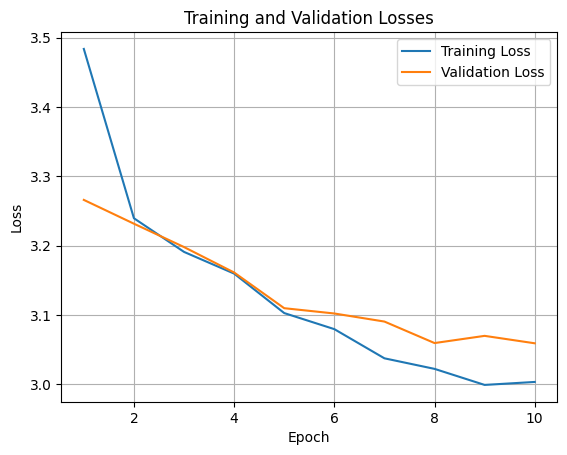

In [80]:
trainModel(tuned_wide_resnet101_2_model, 10)

In [81]:
evalModel(tuned_wide_resnet101_2_model, nn.CrossEntropyLoss())

Test Loss: 3.0583, Test Accuracy: 0.6758
